---
title: Gradient Descent with Momentum
author: ["Guntas Singh Saran"]
date: "2024-02-20"
format:
    html:
        code-fold: false
        code-tools: true
jupyter: python3
image: "DL2.gif"
categories: ["Gradient Descent"]

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from latex import latexify, format_axes
import torch
%config InlineBackend.figure_format = "retina"
%matplotlib inline

#### Helper Function for Plotting

In [2]:
def func_plot(x, y, xlabel = None, ylabel = None, title = None):
    latexify(columns = 2, fig_width = 6)
    plt.scatter(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    format_axes(plt.gca())

In [71]:
def create_XYZ(f):
    # Generate data
    # x = np.linspace(-30, 40, 1000)
    # y = np.linspace(-30, 30, 1000)
    
    x = np.linspace(-10, 10, 1000)
    y = np.linspace(85, 115, 1000)
    
    # x = np.linspace(-5, 5, 100)
    # y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)
    
    # Convert to PyTorch tensors
    X_torch = torch.from_numpy(X)
    Y_torch = torch.from_numpy(Y)

    # Evaluate the function
    Z = f(X_torch, Y_torch)
    return X, Y, Z, X_torch, Y_torch


def create_contour(X, Y, Z, ax2, alpha, scatter_pts=None, filled=True, levels=10, mark_levels=False):
    if filled:
        scatter_color='white'
        contour = ax2.contourf(X, Y, Z.detach().numpy(), levels=levels, cmap='magma', alpha=alpha)
    else:
        scatter_color='black'
        contour = ax2.contour(X, Y, Z.detach().numpy(), levels=levels, cmap='magma', alpha=alpha)
    if scatter_pts is not None:
        ax2.scatter(scatter_pts[0], scatter_pts[1], s=10, c=scatter_color)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title('Contour Plot')
    

    # Add a colorbar in between the subplots
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(contour, cax=cax)
    return ax2, contour


def plot_surface_and_contour(f, uv = None, stride=4, alpha=1, scatter_pts=None, filled=True, levels=10):
    X, Y, Z, X_torch, Y_torch = create_XYZ(f)

    # Create the single figure with two subplots
    fig = plt.figure()

    # Plot the 3D surface on the first subplot
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_surface(X, Y, Z.detach().numpy(), cmap='magma', edgecolor='none', alpha=alpha)  # Remove grid lines
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('z')
    ax1.grid(False)
    ax1.xaxis.pane.fill = False
    ax1.yaxis.pane.fill = False
    ax1.zaxis.pane.fill = False
    ax1.view_init(elev=30, azim=30)
    ax1.set_title('Surface Plot')
    if scatter_pts is not None:
        ax1.scatter(scatter_pts[0], scatter_pts[1], f(scatter_pts[0], scatter_pts[1]), s=100, c='black')
    

    # Plot the contour plot on the second subplot
    ax2 = fig.add_subplot(122, aspect='equal')  # Set 1:1 aspect ratio
    
    ax2, contour = create_contour(X, Y, Z, ax2, alpha, scatter_pts, filled, levels)
    if uv is not None:
        u = uv[0](X_torch, Y_torch)
        v = uv[1](X_torch, Y_torch)
        # Quiver plot for gradient
        ax2.quiver(X[::stride, ::stride], Y[::stride, ::stride], u[::stride, ::stride].detach().numpy(),
                   v[::stride, ::stride].detach().numpy(), scale=140)

        
    plt.tight_layout(pad=1.0, w_pad=1.0)

# Example usage:
# Define your function f(x, y) and its gradient g(x, y)
#f = lambda x, y: x**2 + y**2
#g = lambda x, y: (2*x, 2*y)
#plot_surface_and_contour(f, "x_squared_plus_y_squared", uv=(lambda x, y: 2*x, lambda x, y: 2*y))

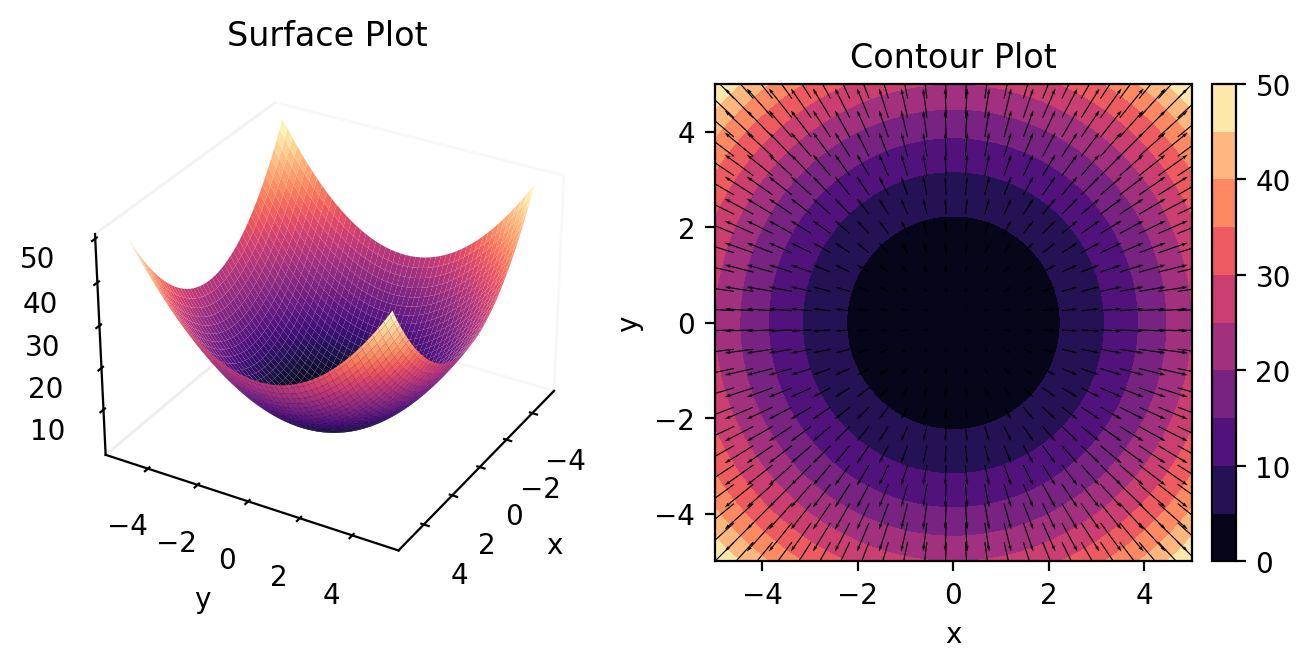

In [7]:
plot_surface_and_contour(lambda x, y: x**2 + y**2, uv=(lambda x, y: 2*x, lambda x, y: 2*y))

#### Dataset1 $y = 100x + 1 + \epsilon$

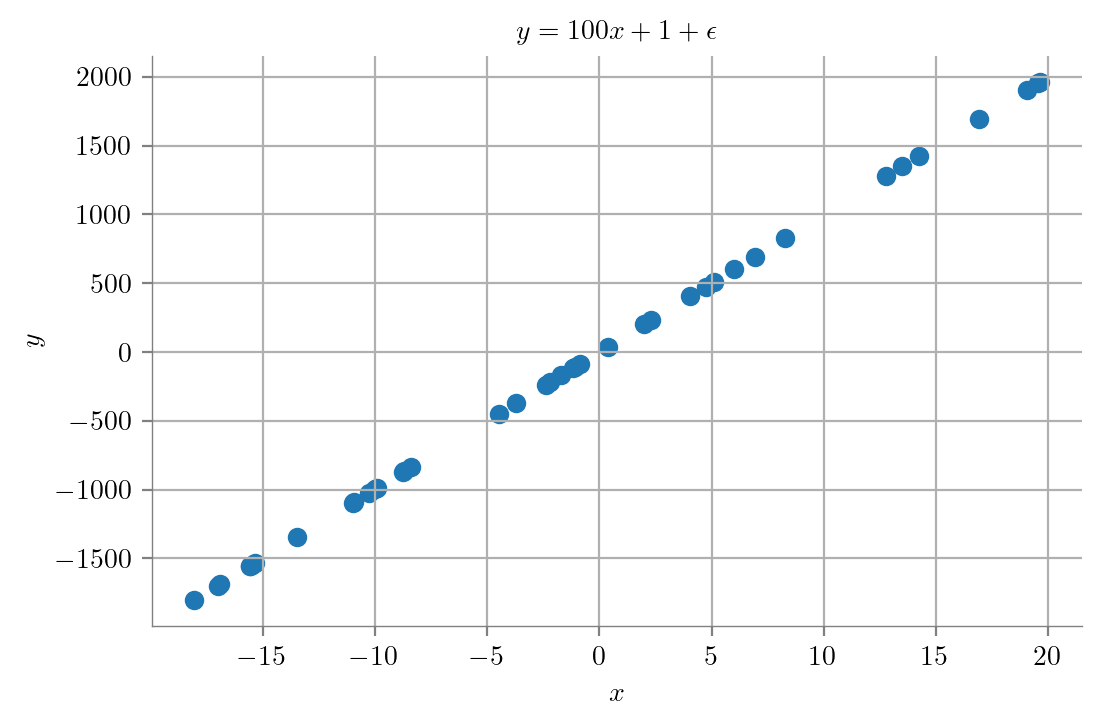

In [25]:
latexify(columns = 2, fig_width = 6)
num_samples = 40
np.random.seed(45) 
    
# Generate data
x1 = np.random.uniform(-20, 20, num_samples)
f_x = 100*x1 + 1
eps = np.random.randn(num_samples)
y1 = f_x + eps

func_plot(x1, y1, xlabel = "$x$", ylabel = "$y$", title = "$y = 100x + 1 + \epsilon$")

#### Dataset2 $y = 3x + 4 + \epsilon$

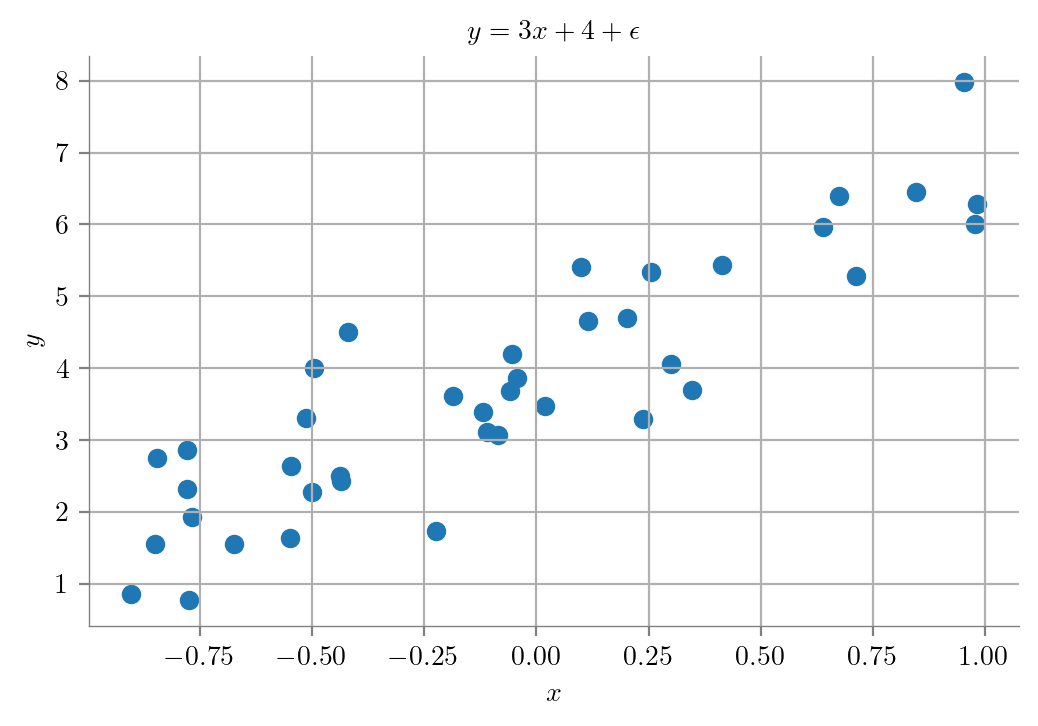

In [35]:
np.random.seed(45)
num_samples = 40
    
# Generate data
x2 = np.random.uniform(-1, 1, num_samples)
f_x = 3*x2 + 4
eps = np.random.randn(num_samples)
y2 = f_x + eps

func_plot(x2, y2, xlabel = "$x$", ylabel = "$y$", title = "$y = 3x + 4 + \epsilon$")

## Calculation
#### $\hat{y_i} = \theta_0 + \theta_1x_i$
#### $\epsilon_i(\theta_0, \theta_1) = y_i - \hat{y_i} = y_i - \theta_0 - \theta_1x_i$

## Loss Function - MSE
#### $$L(\theta_0, \theta_1) = \frac{1}{N} \underset{i}{\operatorname{\sum}} \epsilon_i^2(\theta_0, \theta_1)$$
#### $\frac{\partial L(\theta_0, \theta_1)}{\partial \theta_0} = \frac{2}{N} \underset{i}{\operatorname{\sum}} (y_i - \theta_0 - \theta_1x_i)(-1) = \frac{2}{N} \underset{i}{\operatorname{\sum}} \epsilon_i(-1)$
#### $\frac{\partial L(\theta_0, \theta_1)}{\partial \theta_1} = \frac{2}{N} \underset{i}{\operatorname{\sum}} (y_i - \theta_0 - \theta_1x_i)(-x_i) = \frac{2}{N} \underset{i}{\operatorname{\sum}} \epsilon_i(-x_i)$

## Gradient Descent $\alpha \approx 0.0 - 0.1$ with Momentum $p \approx 0.9 - 1.0$
#### $$ \Delta \theta_0^i = p \Delta \theta_0^{i - 1} + (1 - p) \frac{\partial L^i(\theta_0, \theta_1)}{\partial \theta_0} $$
#### $$ \Delta \theta_1^i = p \Delta \theta_1^{i - 1} + (1 - p) \frac{\partial L^i(\theta_0, \theta_1)}{\partial \theta_1} $$
#### $$ \theta_0^{i + 1} = \theta_0^i - \alpha \Delta \theta_0^i $$
#### $$ \theta_1^{i + 1} = \theta_1^i - \alpha \Delta \theta_1^i $$

### The Coefficients of $L(\theta_0, \theta_1)$ Function
$L(\theta_0, \theta_1) = \frac{1}{N} \underset{i}{\operatorname{\sum}} \epsilon_i^2(\theta_0, \theta_1) = \frac{1}{N} \underset{i}{\operatorname{\sum}} (y_i - \theta_0 - \theta_1x_i)^2$ <br>
$ = \frac{1}{N} \underset{i}{\operatorname{\sum}} ((y_i)^2 + (\theta_0)^2 + (\theta_1x_i)^2 - 2y_i\theta_0 + 2\theta_0 \theta_1 x_i - 2\theta_1 x_i y_i)$ <br>
$L(\theta_0, \theta_1) = \frac{1}{N} (1 \times (\underset{i}{\operatorname{\sum}}y_i^2) + \theta_0 \times (-2 \underset{i}{\operatorname{\sum}} y_i) + \theta_1 \times (-2 \underset{i}{\operatorname{\sum}} x_iy_i) + \theta_0^2 \times (N) + \theta_1^2 \times (\underset{i}{\operatorname{\sum}} x_i^2) + \theta_0\theta_1 \times (2 \underset{i}{\operatorname{\sum}} x_i))$ <br>
$$ L(\theta_0, \theta_1) = 1 \times (c_0) + \theta_0 \times (c_1) + \theta_1 \times (c_2) + \theta_0^2 \times (c_3) + \theta_1^2 \times (c_4) + \theta_0\theta_1 \times (c_5) $$

## Dataset1

In [26]:
def generate_coeff(x, y):
    N = len(x)
    return np.sum(y**2)/N, -2 * np.sum(y)/N, -2 * np.sum(x * y)/N, 1, np.sum(x**2)/N, 2 * np.sum(x)/N

In [27]:
def L(th0, th1):
    c0, c1, c2, c3, c4, c5 = generate_coeff(x1, y1)
    return c0 + c1*th0 + c2*th1 + c3*th0**2 + c4*th1**2 + c5*th0*th1

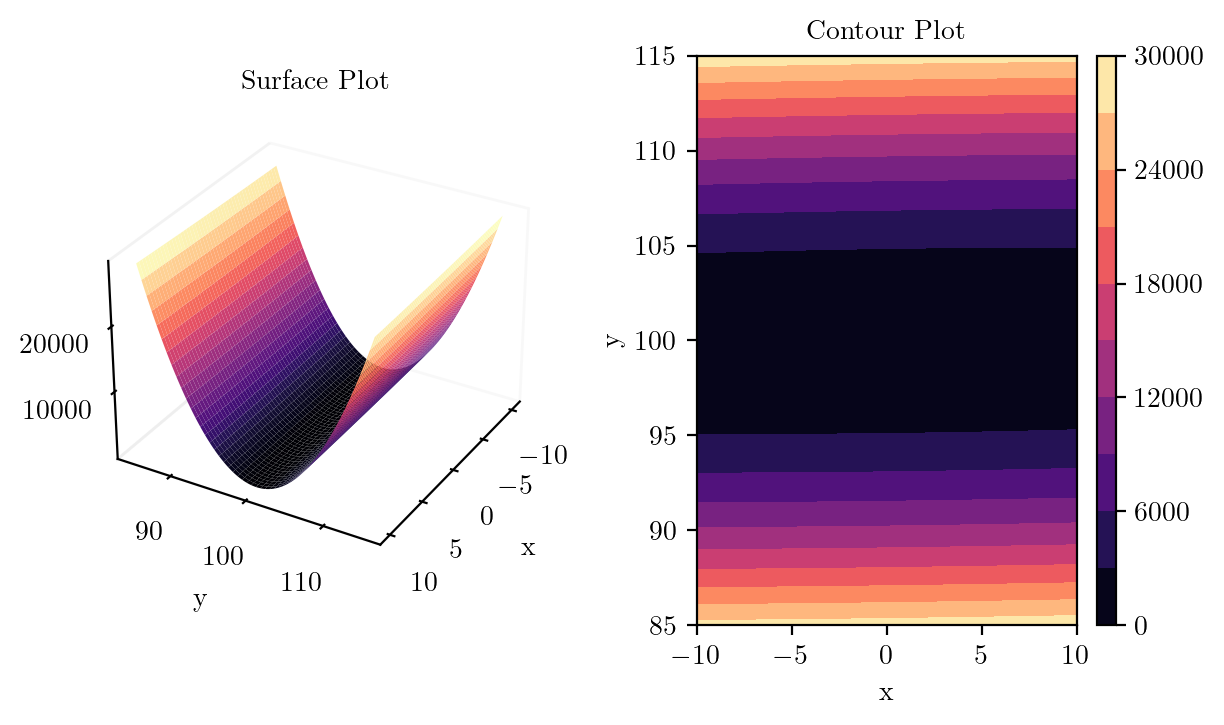

In [28]:
plot_surface_and_contour(L)

In [32]:
x0, y0 = torch.tensor(1.0), torch.tensor(93.0)
v0, v1 = torch.tensor(0.0), torch.tensor(0.0)
del_x, del_y = torch.func.grad(L, argnums=(0, 1))(x0, y0)
print(del_x, del_y)

tensor(23.7581) tensor(-1764.8730)


In [30]:
def visualiz̀e_descent(L, x0, y0, v0, v1, levels, folderName, filename, t0, t1, alpha, p):
    losses = []
    latexify(columns=2, fig_width=6.5, fig_height=3)
    X, Y, Z, X_torch, Y_torch = create_XYZ(L)

    epsilon = 1e-3

    xi = x0
    yi = y0
    
    vi = v0
    wi = v1
    
    
    for i in range(15):
        fig, ax = plt.subplots(ncols=2)
        _, _ = create_contour(X, Y, Z, ax[0], alpha=0.8, scatter_pts=(xi, yi), filled=True, levels = levels)
        # Mark the minima with horizontal and vertical lines
        ax[0].axhline(y=yi, color='red', linestyle='--', alpha=0.7)
        ax[0].axvline(x=xi, color='red', linestyle='--', alpha=0.7)
        ax[0].scatter([t0], [t1], s=10, c='pink', marker='x', label='Minima')
        del_x, del_y = torch.func.grad(L, argnums=(0, 1))(xi, yi)
        
        vi = p * vi + (1 - p) * del_x  
        wi = p * wi + (1 - p) * del_y
        
        xi = xi - alpha * vi
        yi = yi - alpha * wi
        
        losses.append(L(xi, yi))
        print(f"Epoch No. {i + 1} -> {xi}, {yi}, Loss: {L(xi, yi)}")
        if (torch.linalg.norm(torch.tensor([xi - t0, yi - t1])) < epsilon):
            break
        
        # plot the line fit 
        x_line = np.linspace(-10, 10, 100)
        y_line = xi + yi*x_line
        ax[1].plot(x_line, y_line, label='Line fit')
        # ax[1].set_ylim(-1, 7)
        ax[1].plot(x_line, t1*x_line + t0, label='Actual line')
        ax[1].legend()
        
        plt.tight_layout()
        plt.savefig(f"./{folderName}/{filename}-{i}.png", bbox_inches="tight")
    
    return losses

Epoch No. 1 -> 0.9988120794296265, 93.08824157714844, Loss: 6009.27734375
Epoch No. 2 -> 0.9964632391929626, 93.26273345947266, Loss: 5709.30419921875
Epoch No. 3 -> 0.9929947853088379, 93.52040100097656, Loss: 5279.908203125
Epoch No. 4 -> 0.988461971282959, 93.85716247558594, Loss: 4743.96630859375
Epoch No. 5 -> 0.9829329252243042, 94.2679672241211, Loss: 4129.1064453125
Epoch No. 6 -> 0.9764877557754517, 94.74688720703125, Loss: 3466.33056640625
Epoch No. 7 -> 0.9692173600196838, 95.28718566894531, Loss: 2788.14013671875
Epoch No. 8 -> 0.961222231388092, 95.88142395019531, Loss: 2127.035888671875
Epoch No. 9 -> 0.9526110887527466, 96.52155303955078, Loss: 1515.26708984375
Epoch No. 10 -> 0.9434993863105774, 97.19902801513672, Loss: 980.5810546875
Epoch No. 11 -> 0.9340077638626099, 97.90491485595703, Loss: 546.472900390625
Epoch No. 12 -> 0.9242605566978455, 98.6300048828125, Loss: 232.1854248046875
Epoch No. 13 -> 0.914384126663208, 99.36495208740234, Loss: 48.958770751953125
Epoc

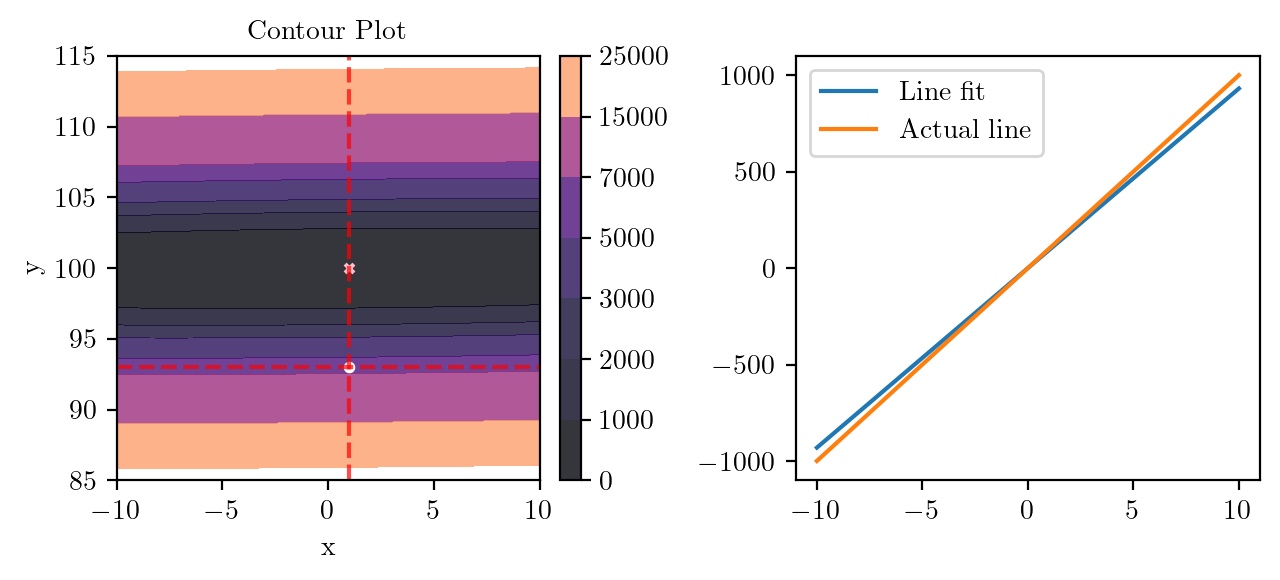

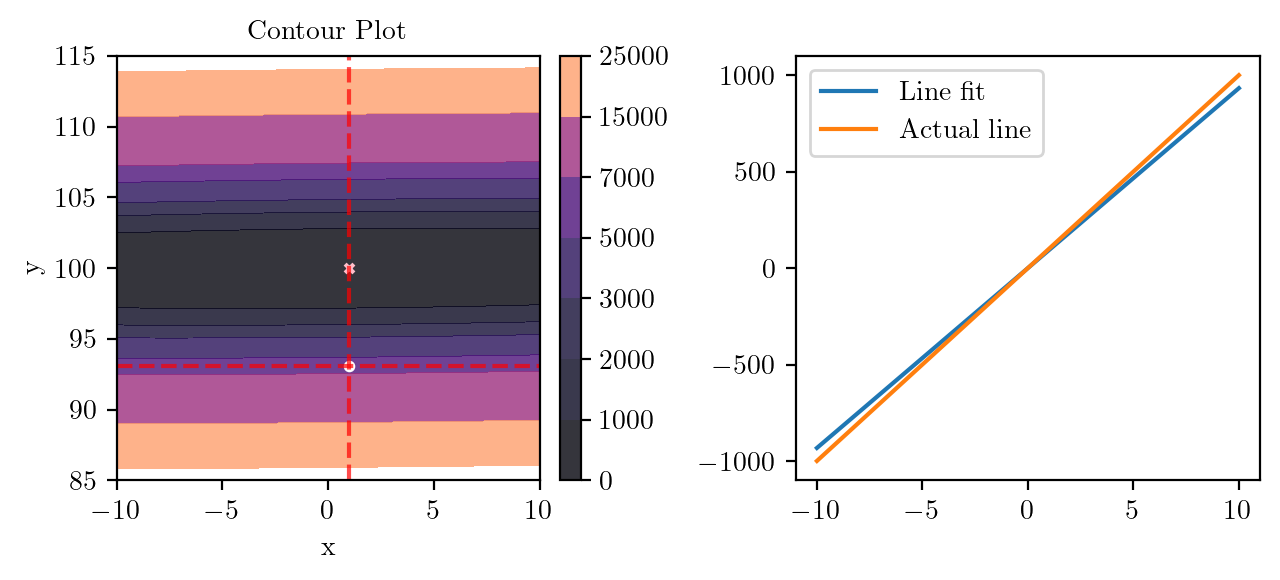

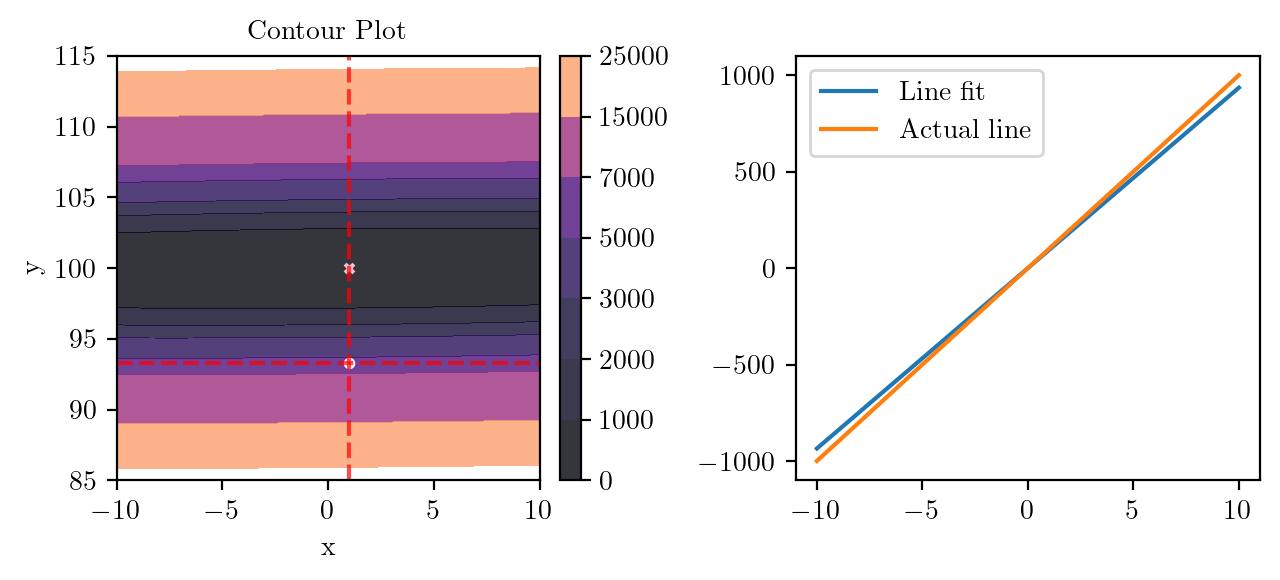

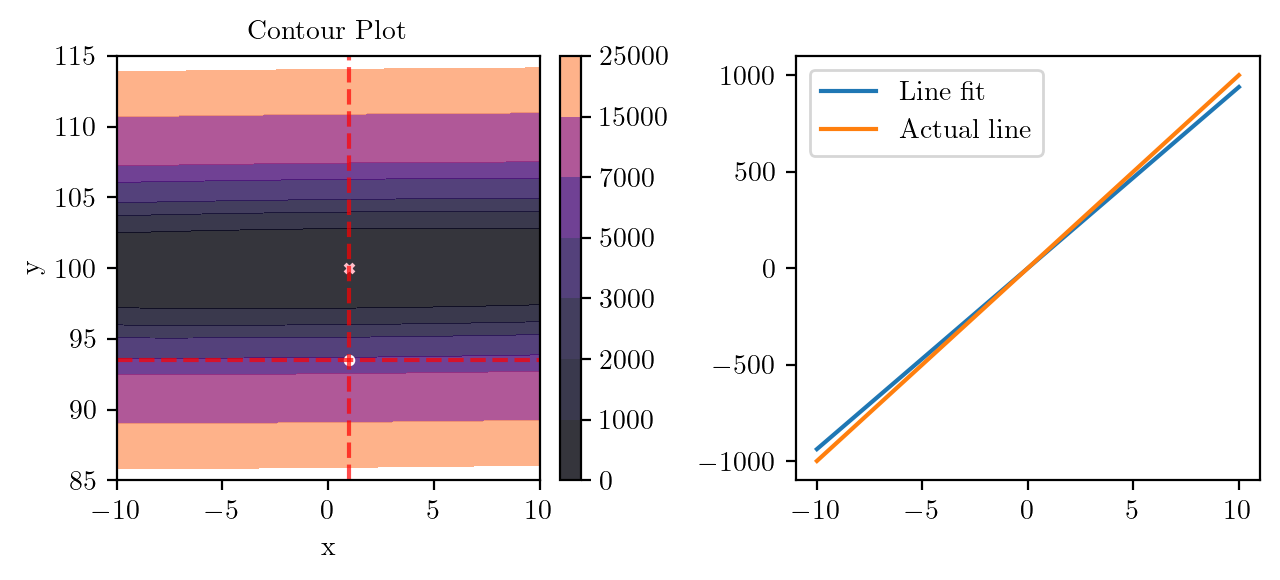

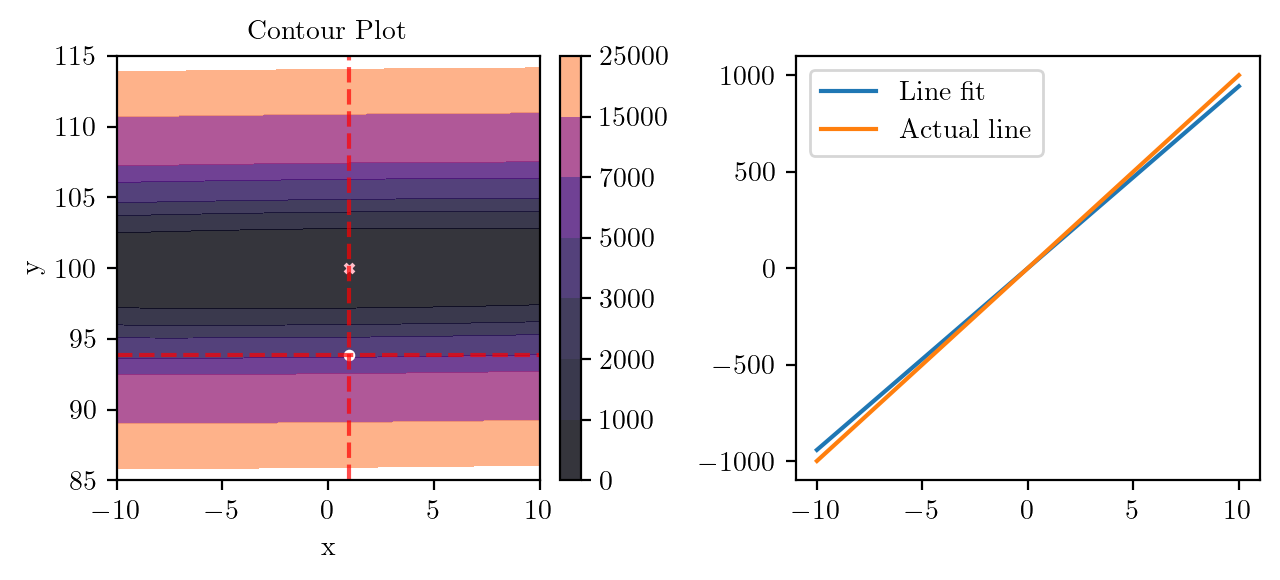

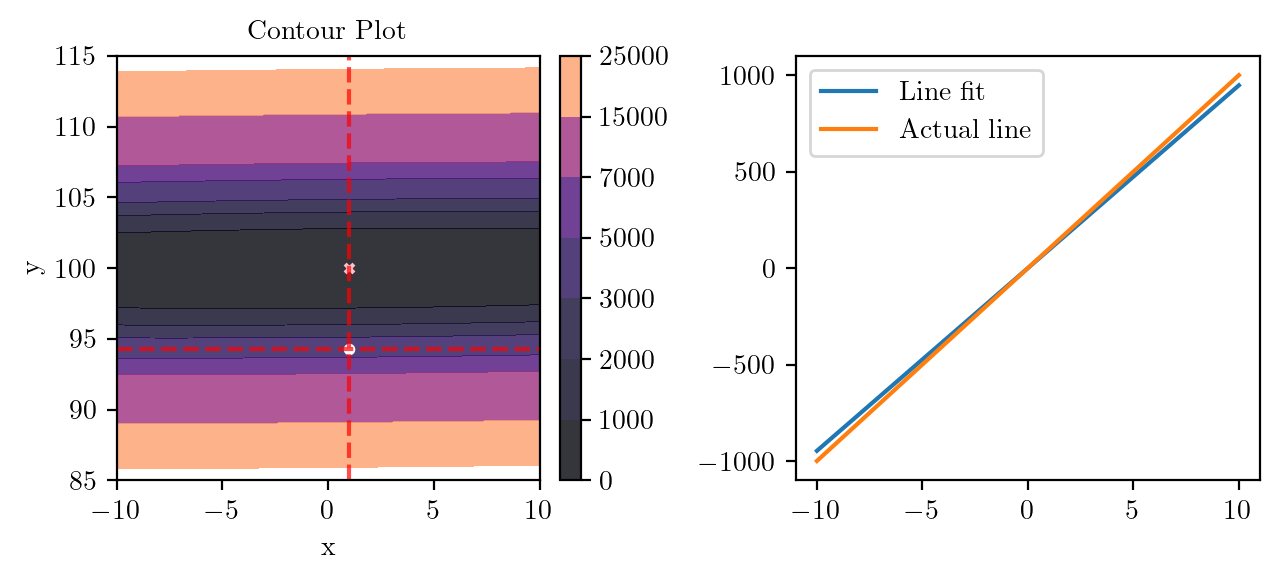

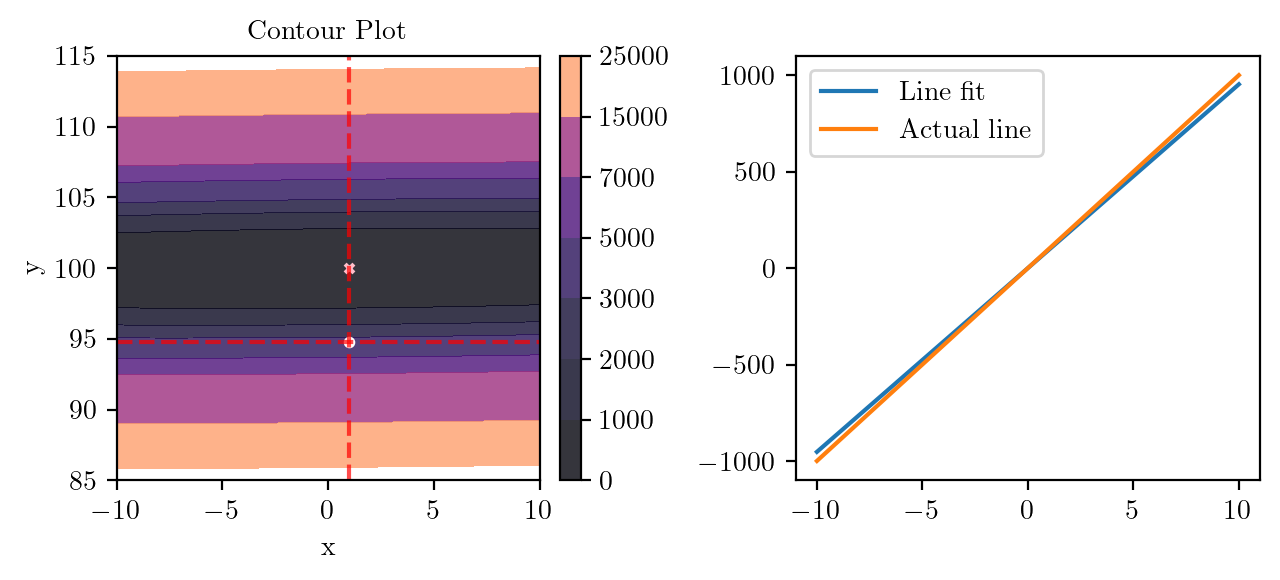

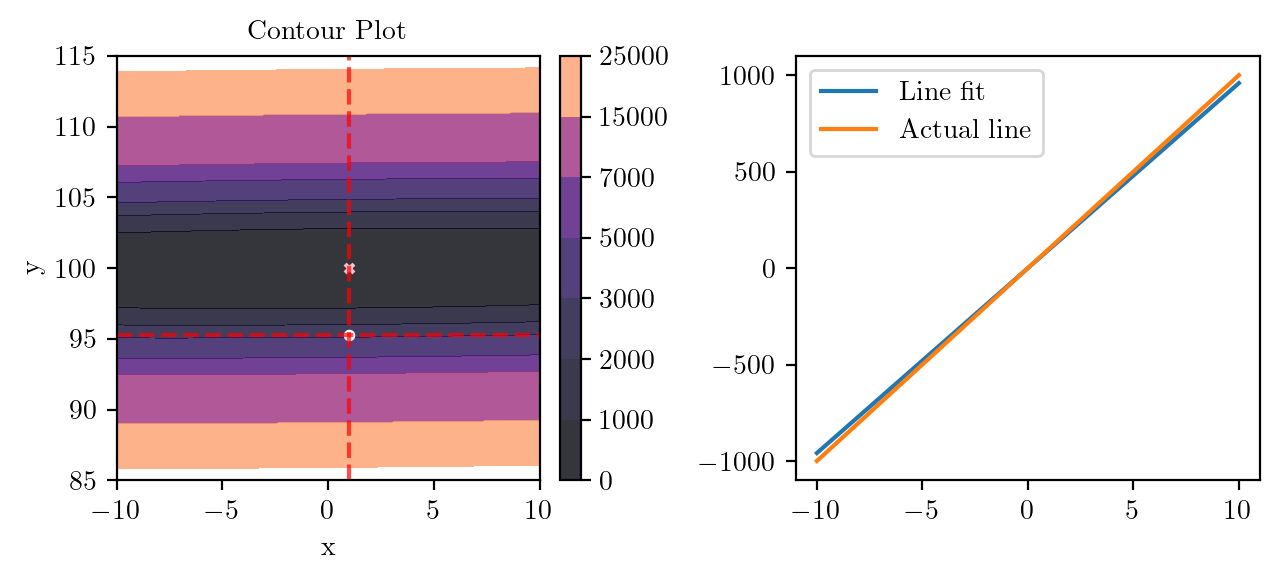

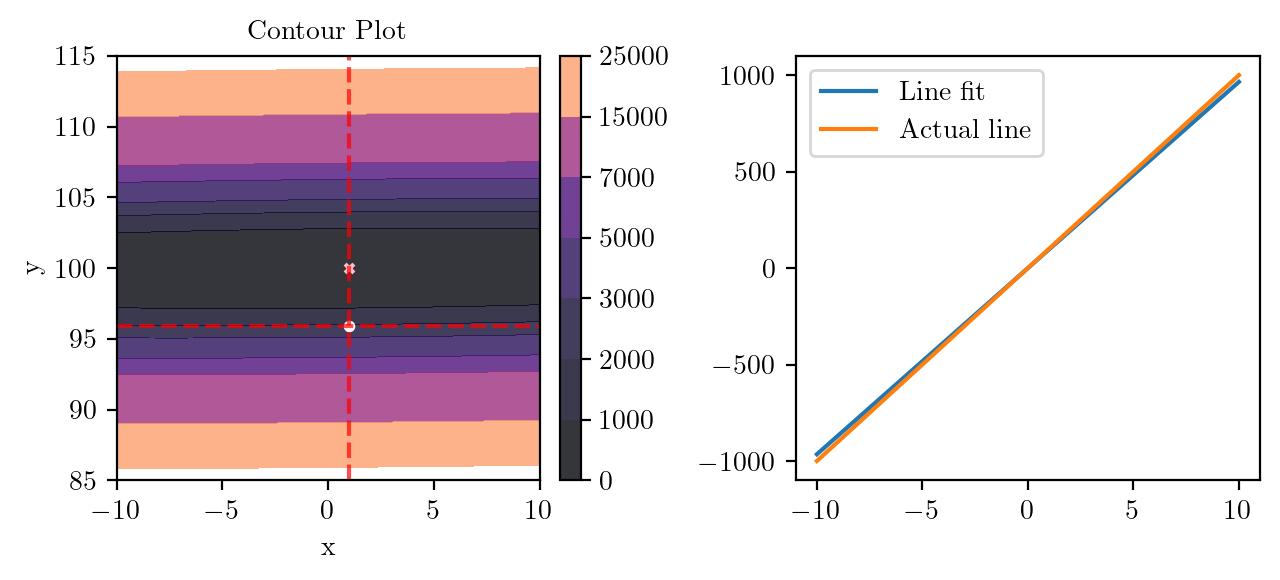

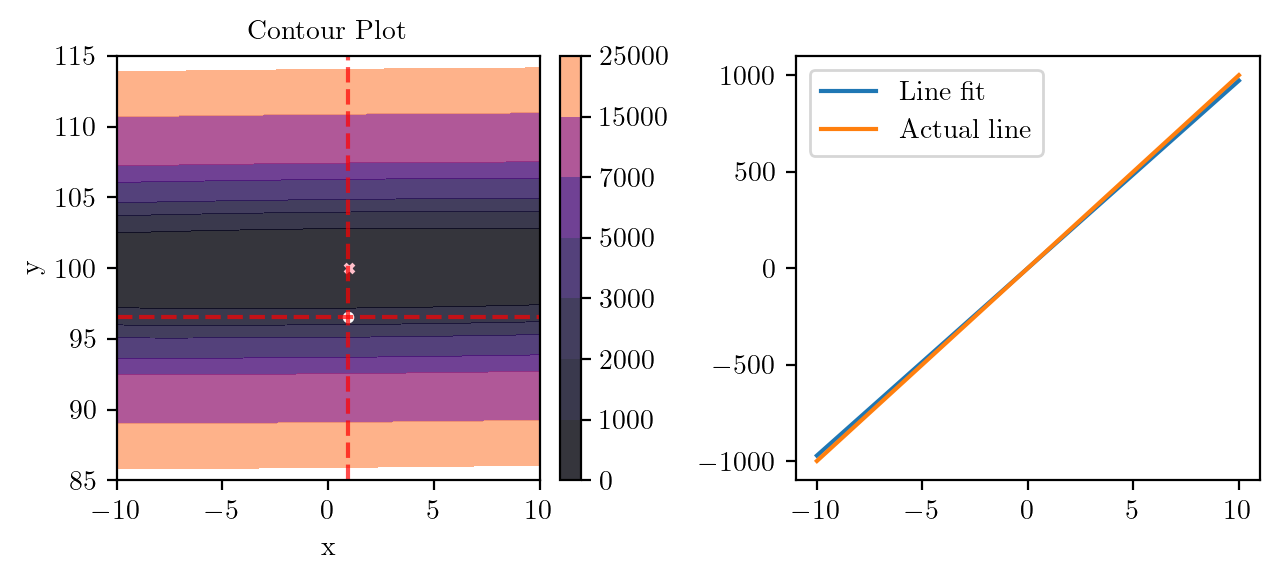

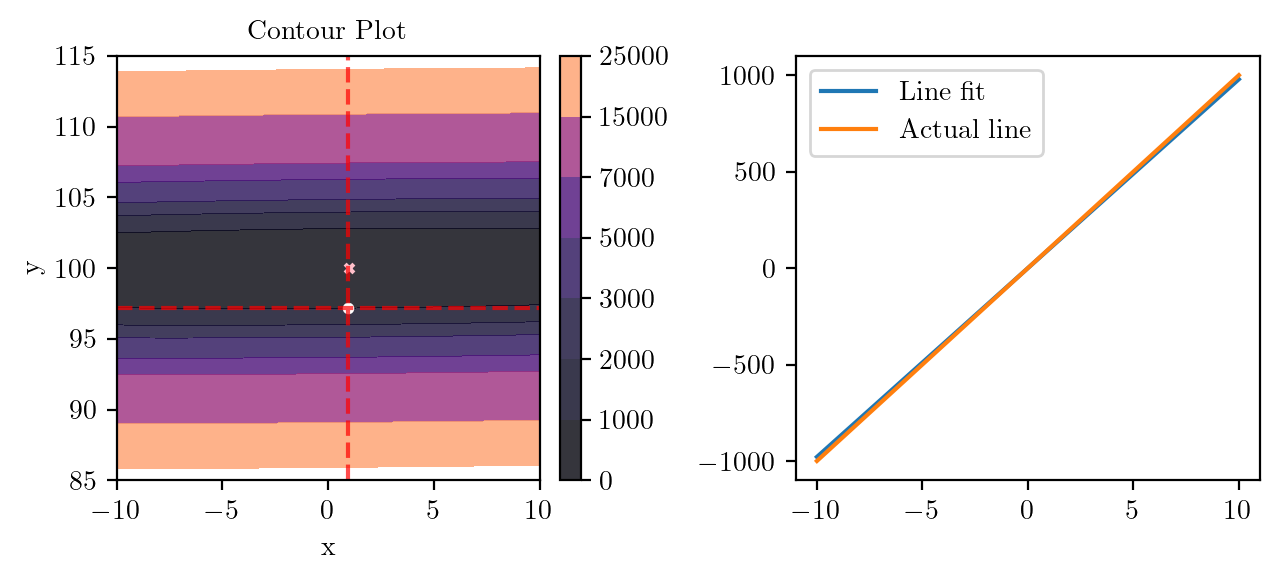

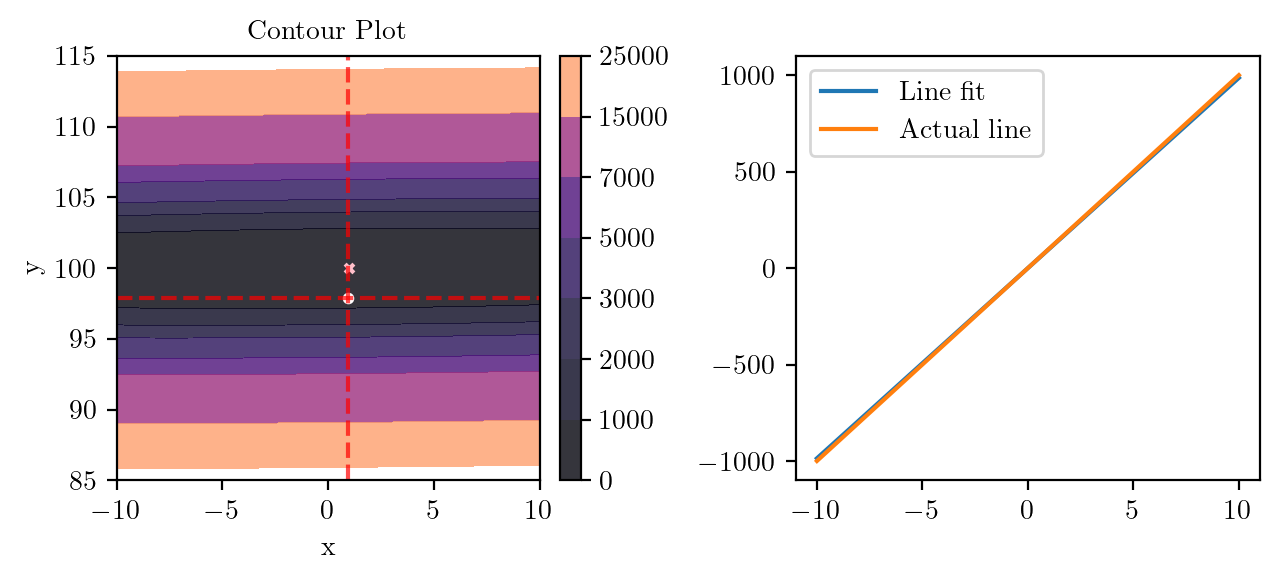

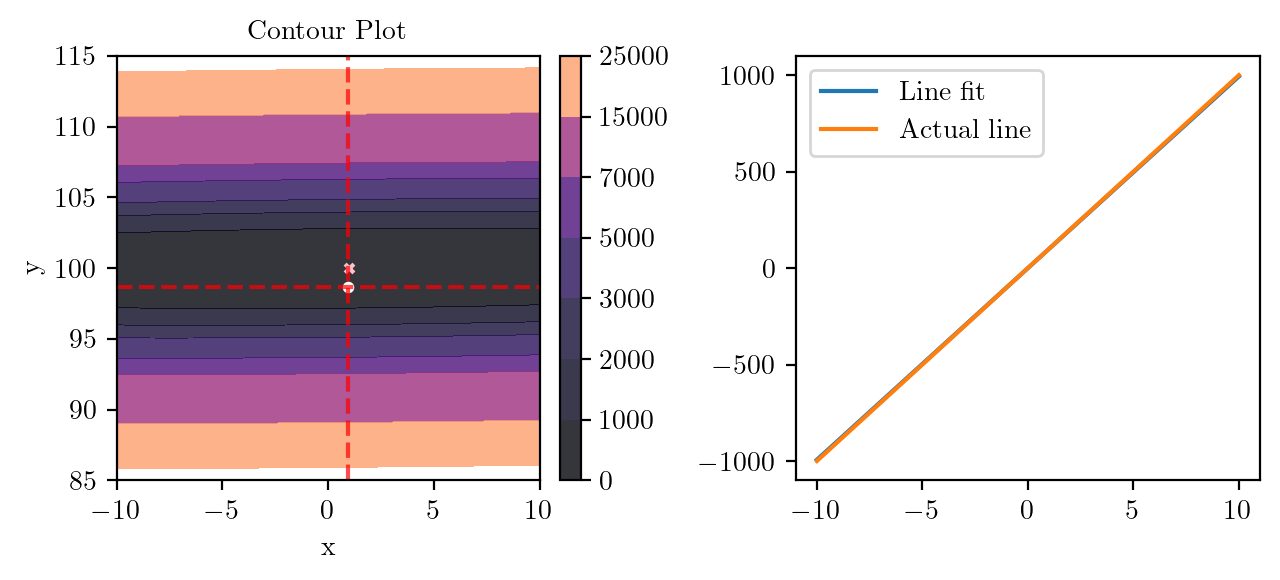

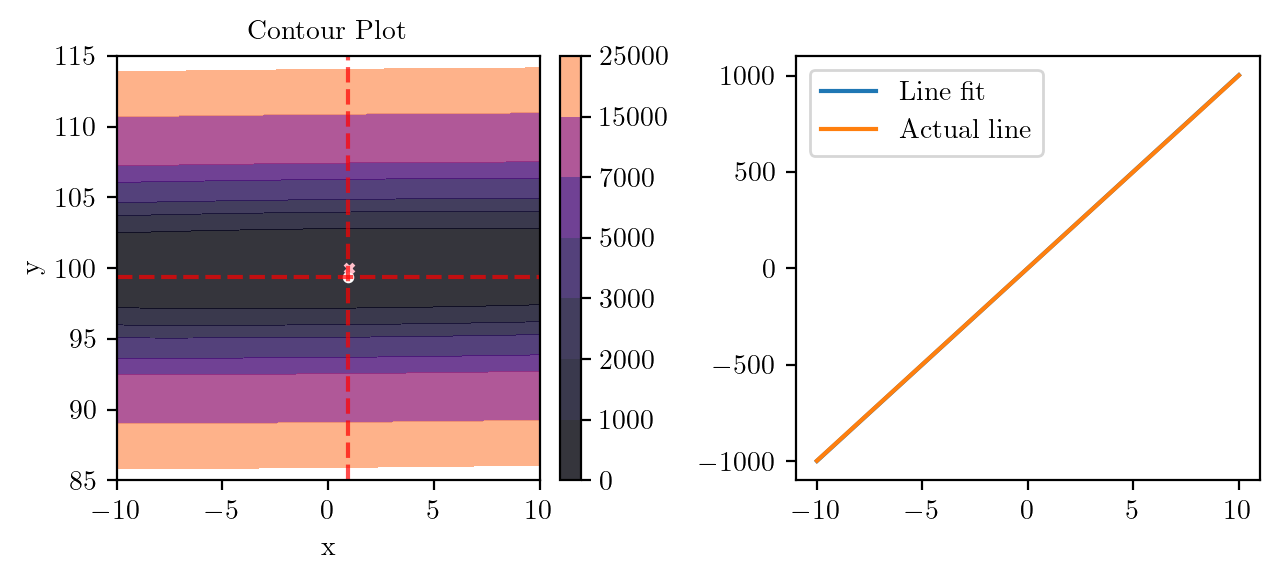

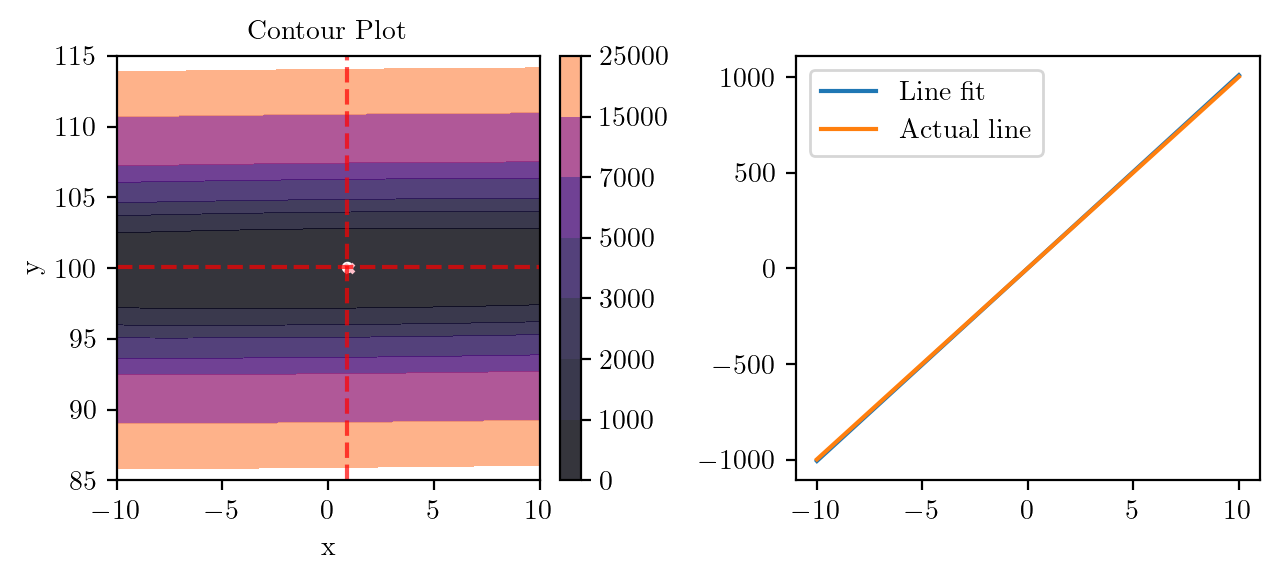

In [33]:
loss1 = visualize_descent(L, x0, y0, v0, v1, [0, 1000, 2000, 3000, 5000, 7000, 15000, 25000], "D1LMedia", "d", 1, 100, 0.005, 0.99)

## Visualization for Dataset1

!["D1"](./AllMedia/DL1.gif)

In [36]:
def loss_plot(loss, xlabel, ylabel, title):
    latexify(columns = 2, fig_width = 6)
    plt.plot(range(1, len(loss) + 1), loss, marker = "o", label = "Loss", color = "green")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.legend()
    format_axes(plt.gca())

In [16]:
epsilon = 0.001

for i in range(1, len(loss1)):
    change_in_loss = np.abs(loss1[i] - loss1[i-1])
    print(change_in_loss)
    if change_in_loss < epsilon:
        print(f"Converged at iteration {i}")
        break

tensor(299.9731)
tensor(429.3960)
tensor(535.9419)
tensor(614.8599)
tensor(662.7759)
tensor(678.1904)
tensor(661.1042)
tensor(611.7688)
tensor(534.6860)
tensor(434.1082)
tensor(314.2875)
tensor(183.2267)
tensor(46.5530)
tensor(88.1059)


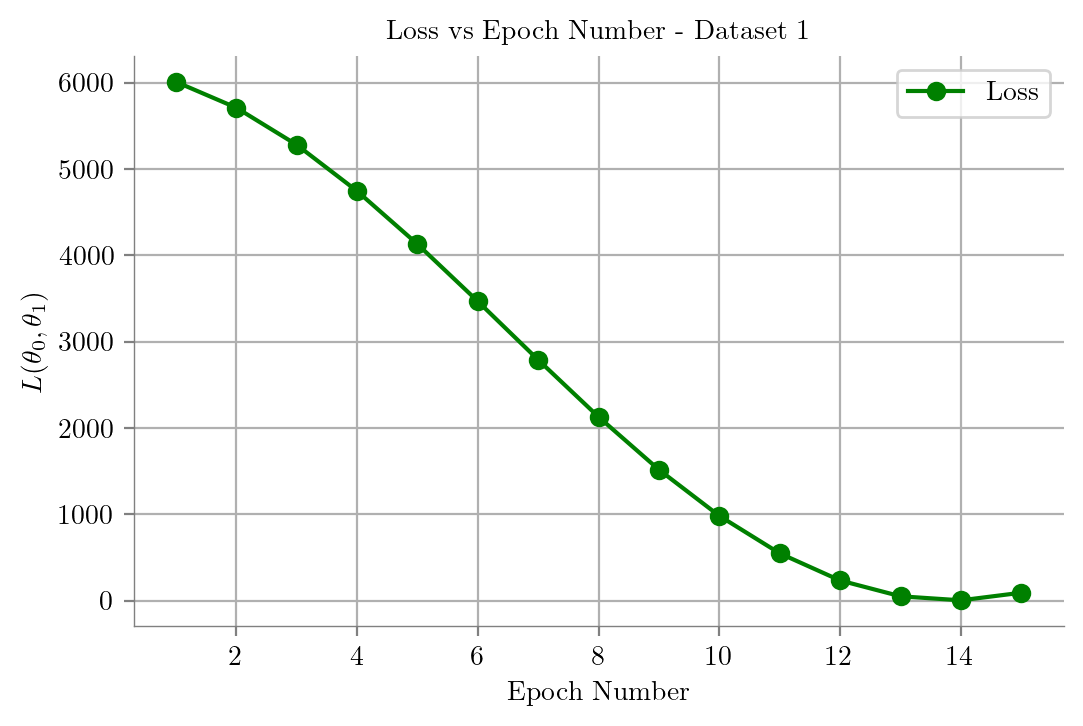

In [17]:
loss_plot(loss1, xlabel = "Epoch Number", ylabel = r"$L(\theta_0, \theta_1)$", title = "Loss vs Epoch Number - Dataset 1")

## Dataset2

In [43]:
def L1(th0, th1):
    c0, c1, c2, c3, c4, c5 = generate_coeff(x2, y2)
    return c0 + c1*th0 + c2*th1 + c3*th0**2 + c4*th1**2 + c5*th0*th1

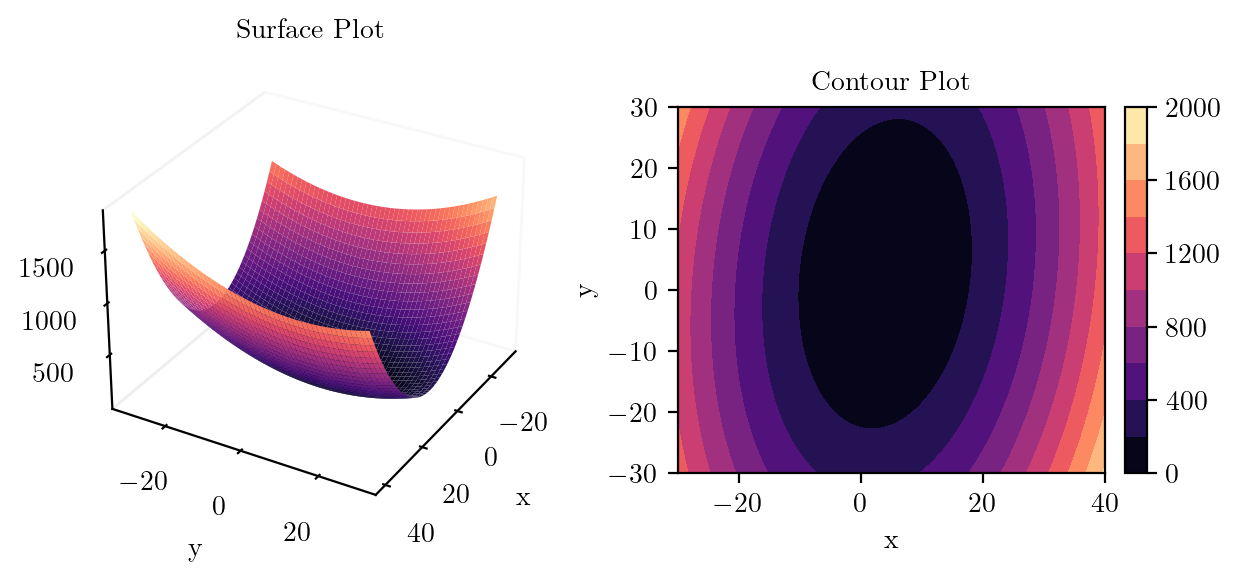

In [38]:
plot_surface_and_contour(L1)

In [55]:
x0, y0 = torch.tensor(35.0), torch.tensor(-25.0)
v0, v1 = torch.tensor(1.0), torch.tensor(0.0)
del_x, del_y = torch.func.grad(L1, argnums=(0, 1))(x0, y0)
print(del_x, del_y)

tensor(66.7875) tensor(-22.7458)


Epoch No. 1 -> 30.638282775878906, -23.57839012145996, Loss: 1049.346435546875
Epoch No. 2 -> 23.753042221069336, -21.192873001098633, Loss: 652.8497924804688
Epoch No. 3 -> 15.861068725585938, -18.251495361328125, Loss: 323.0963439941406
Epoch No. 4 -> 8.231679916381836, -15.0928955078125, Loss: 131.60641479492188
Epoch No. 5 -> 1.7863411903381348, -11.976848602294922, Loss: 67.77926635742188
Epoch No. 6 -> -2.932304859161377, -9.083971977233887, Loss: 77.9818115234375
Epoch No. 7 -> -5.735476016998291, -6.522637367248535, Loss: 106.07808685302734
Epoch No. 8 -> -6.72452974319458, -4.340756416320801, Loss: 117.43630981445312
Epoch No. 9 -> -6.206265449523926, -2.5400781631469727, Loss: 103.38958740234375
Epoch No. 10 -> -4.603233337402344, -1.0909062623977661, Loss: 72.79557800292969
Epoch No. 11 -> -2.3716626167297363, 0.054392099380493164, Loss: 39.935184478759766
Epoch No. 12 -> 0.06448984146118164, 0.9501926302909851, Loss: 15.505937576293945
Epoch No. 13 -> 2.3590428829193115, 1.

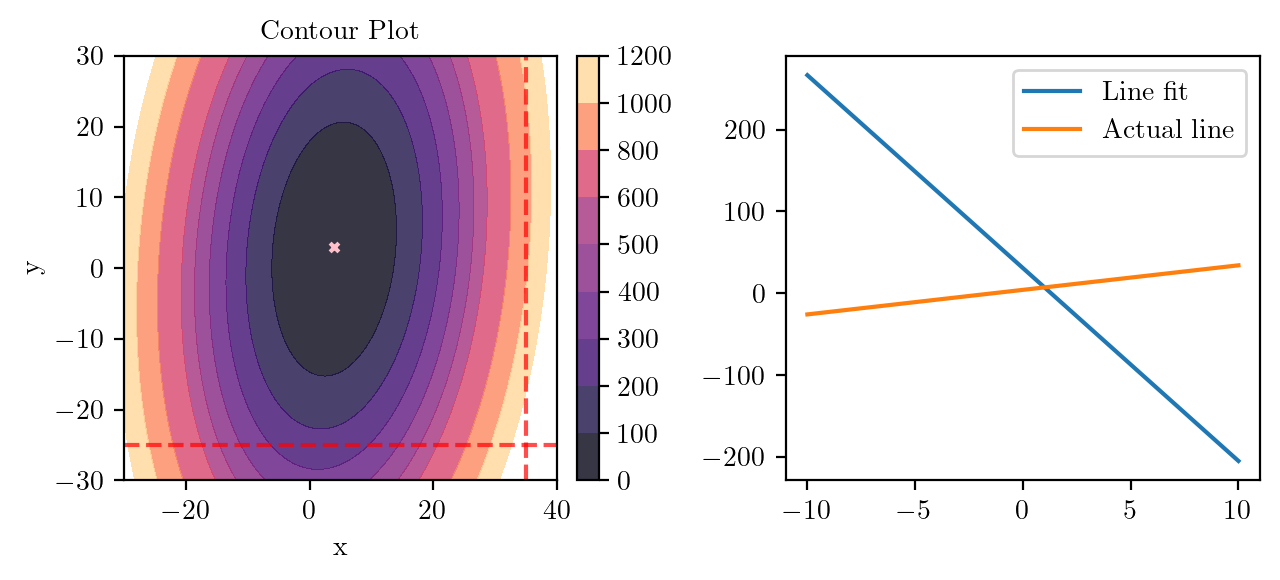

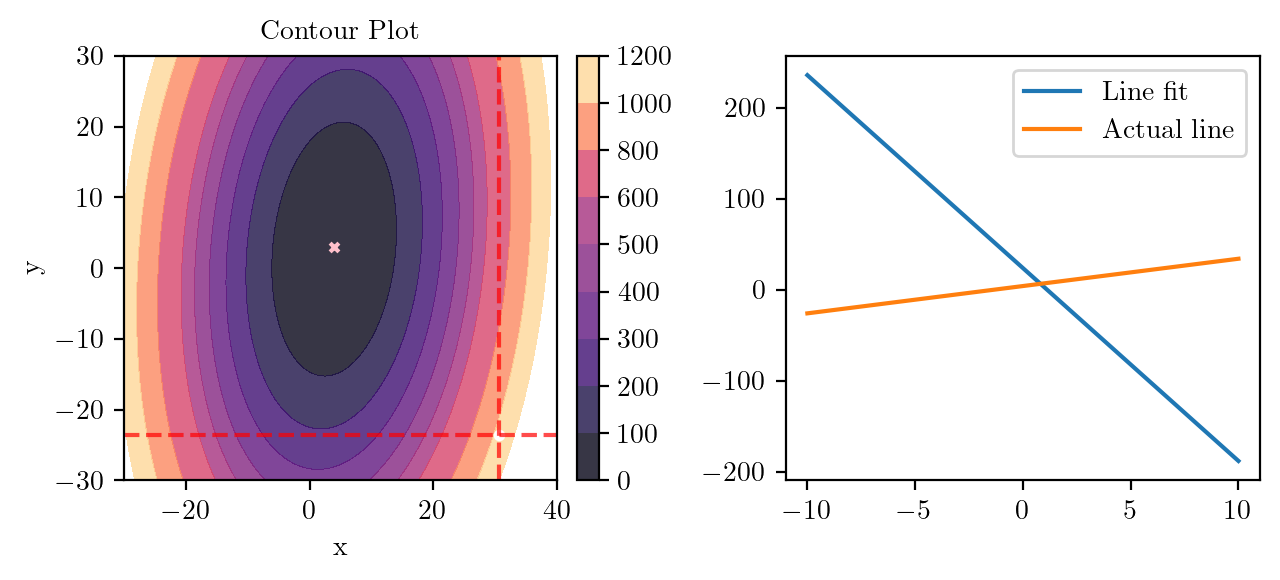

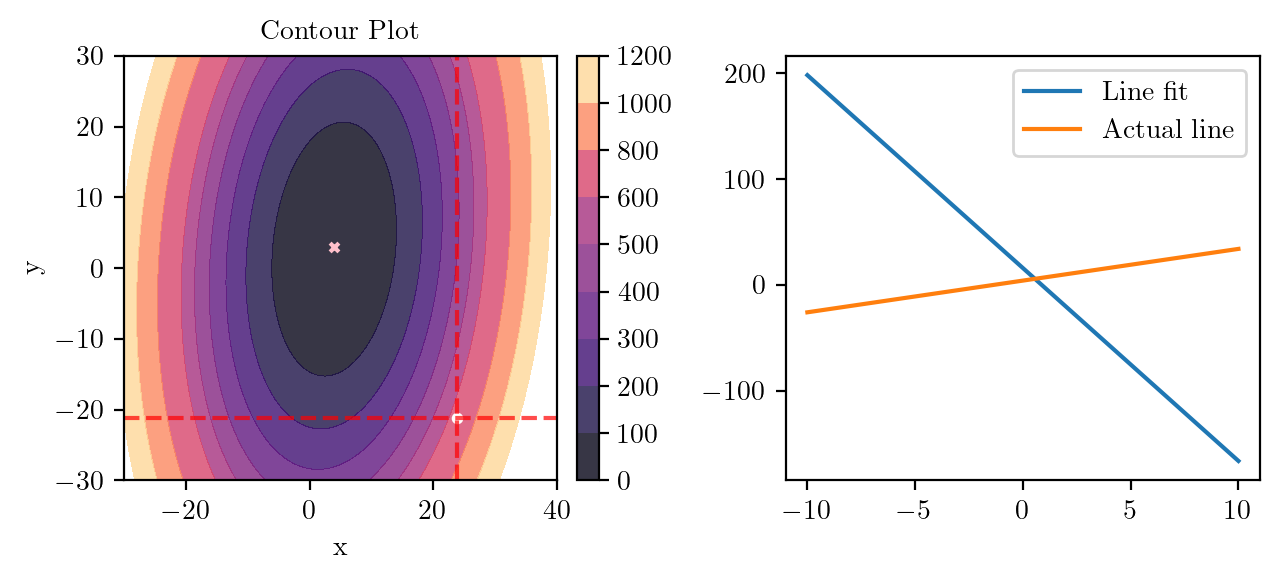

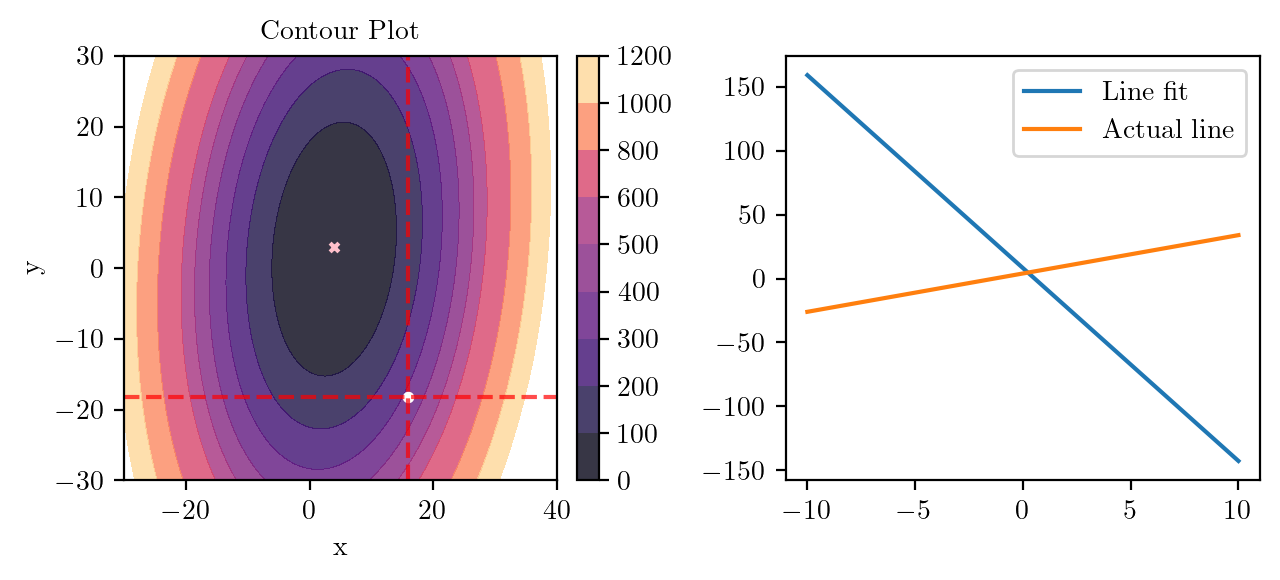

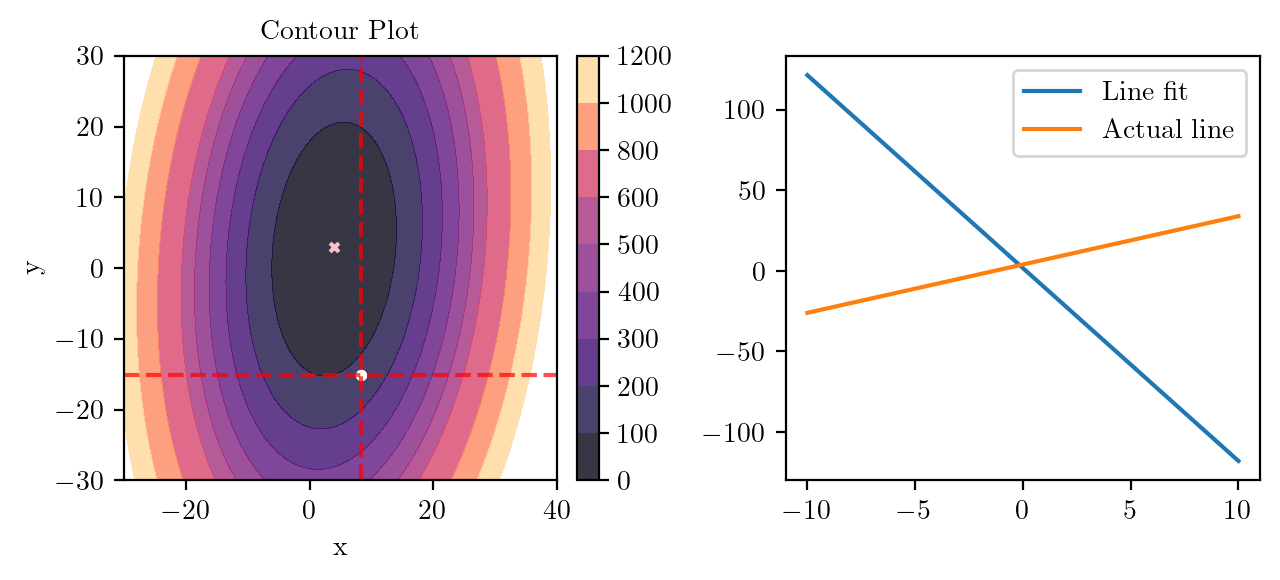

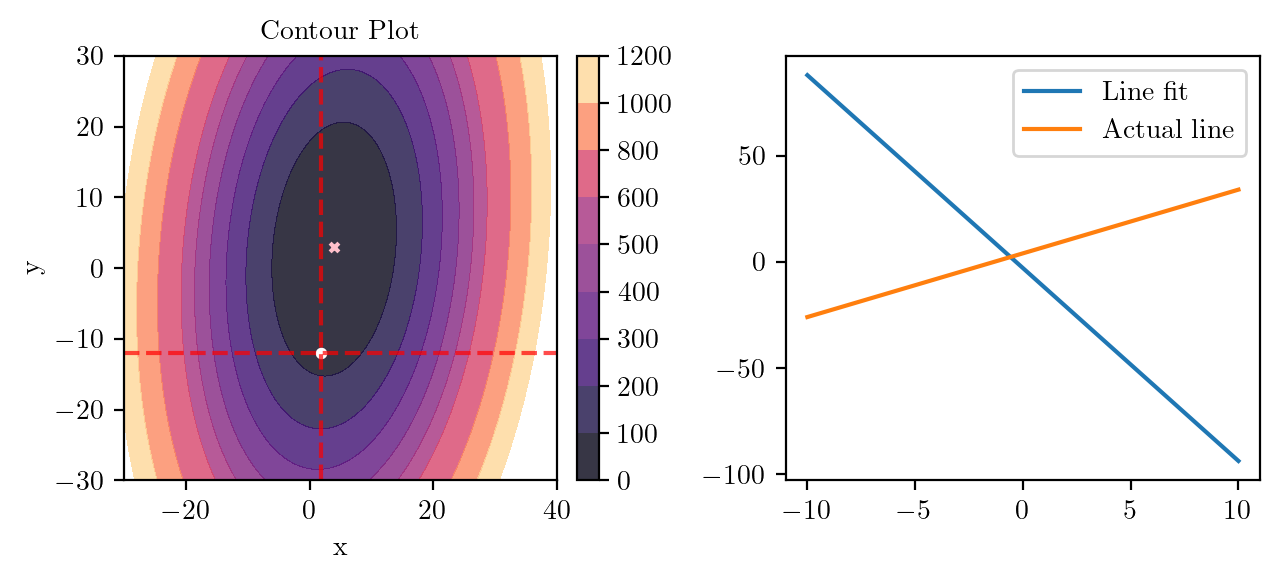

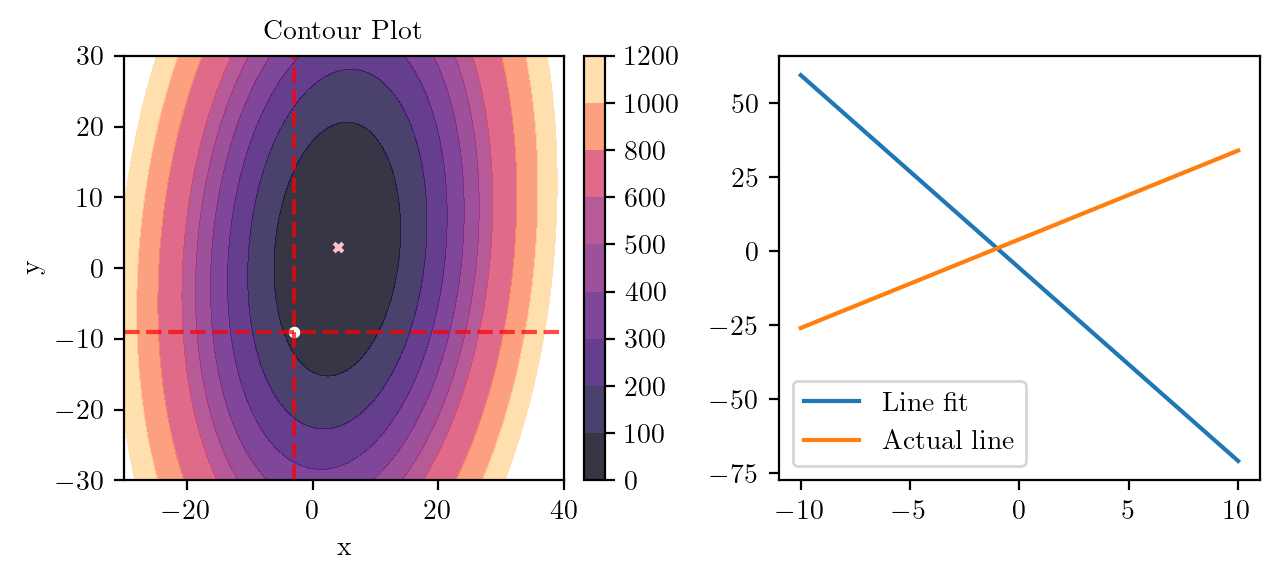

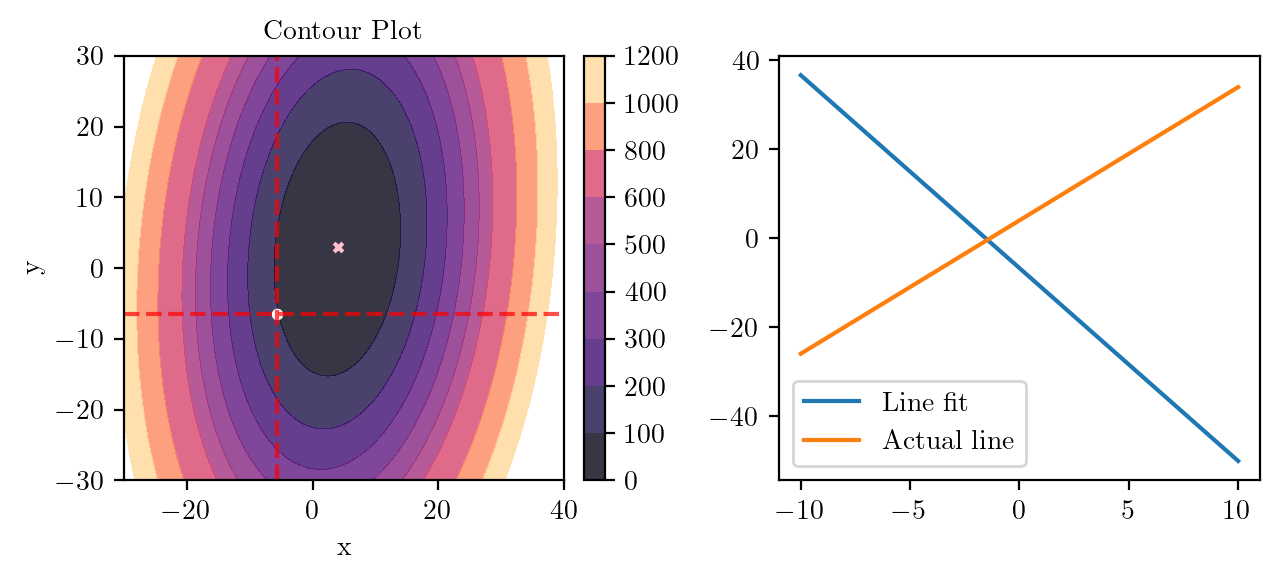

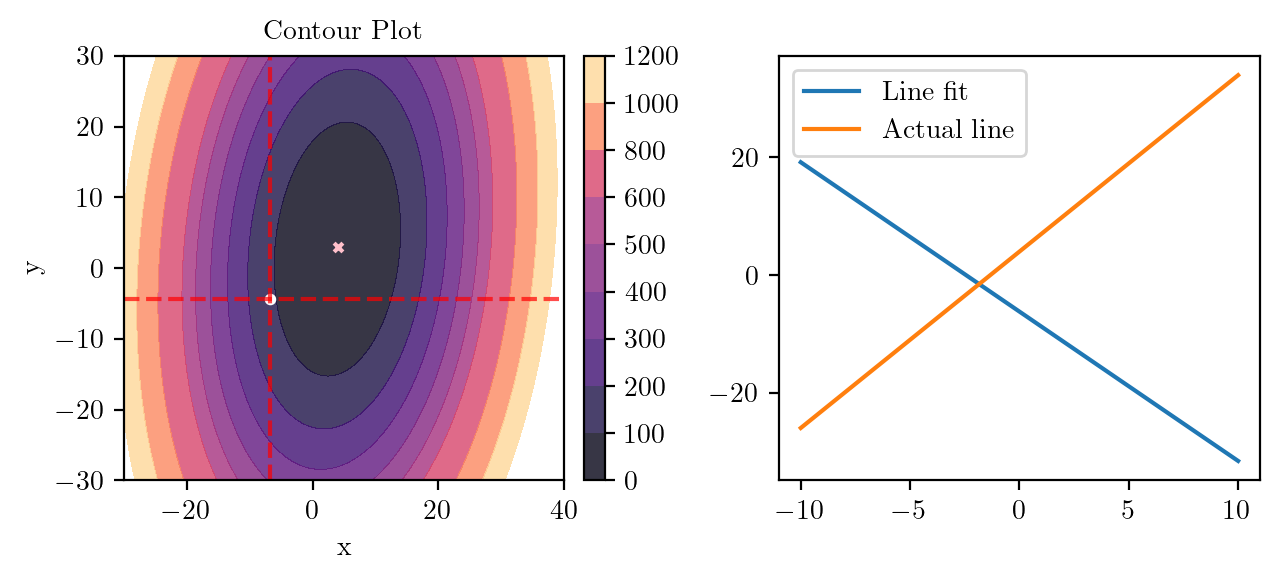

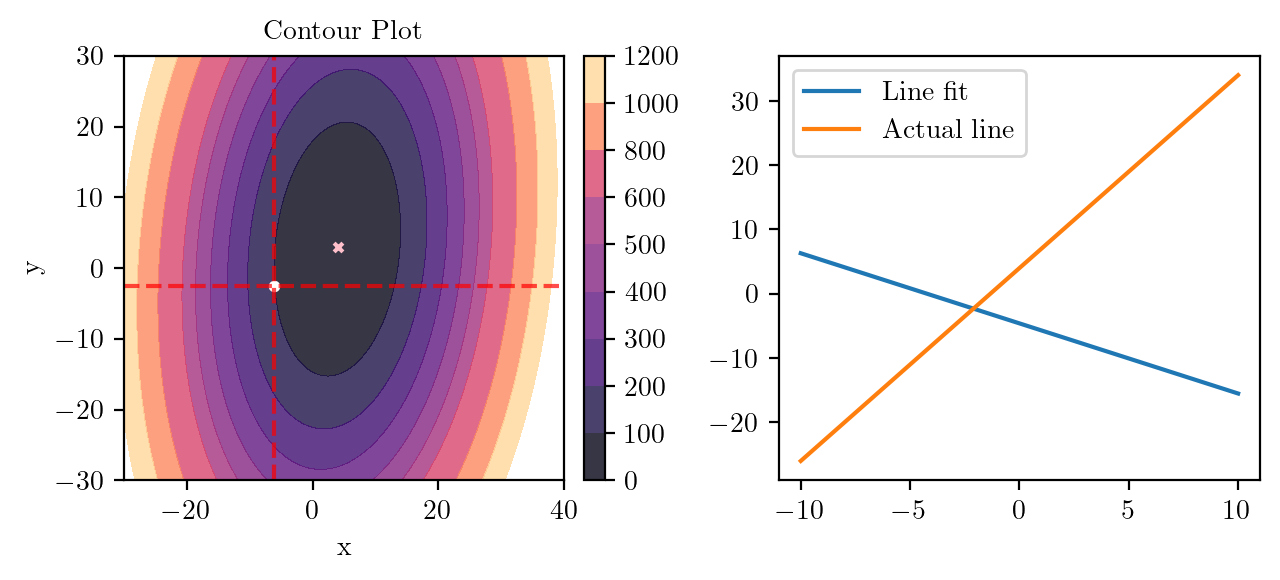

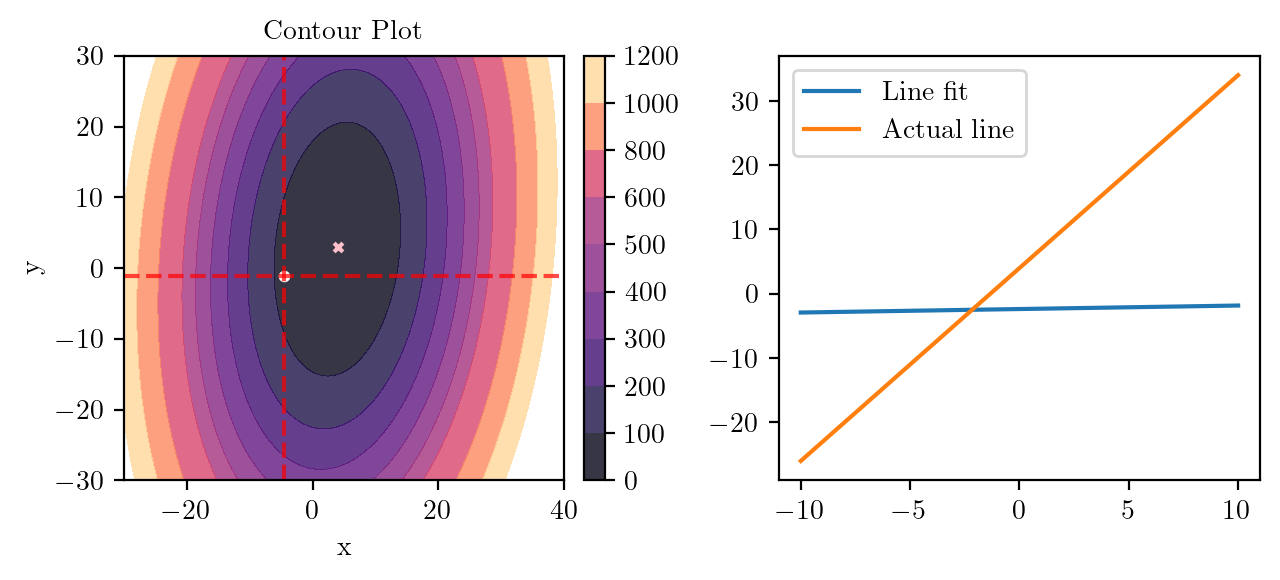

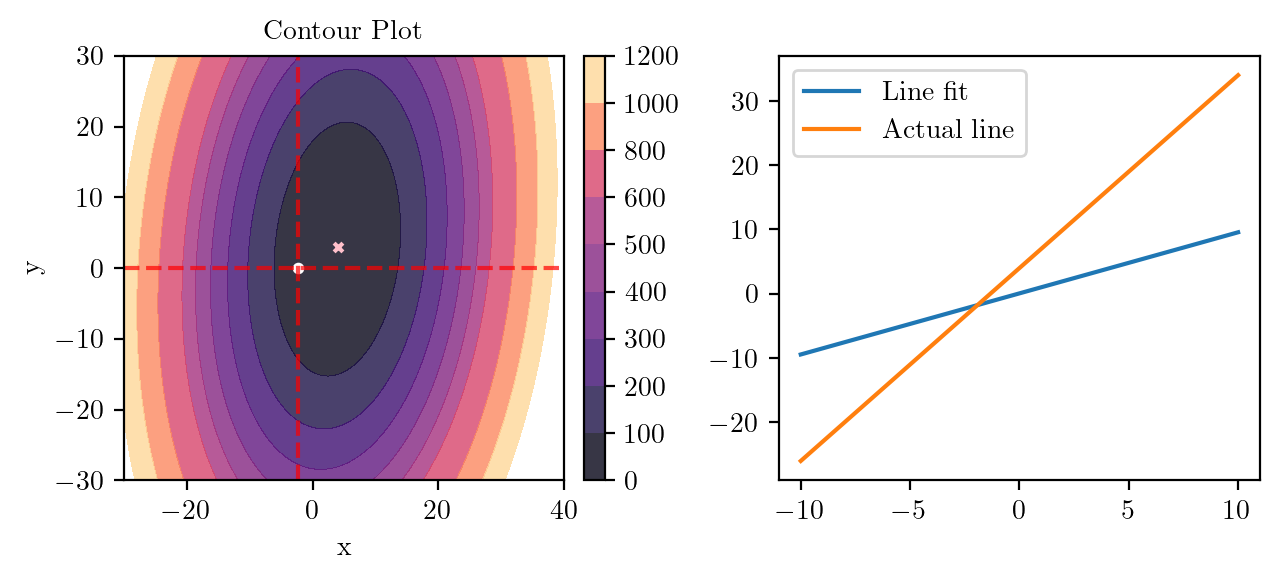

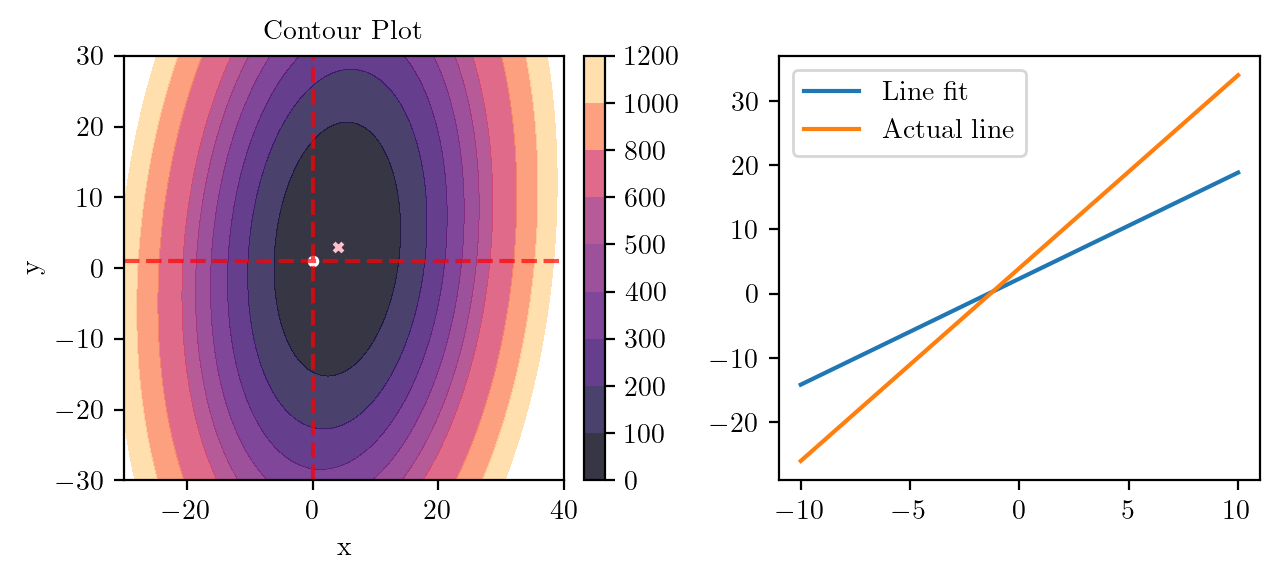

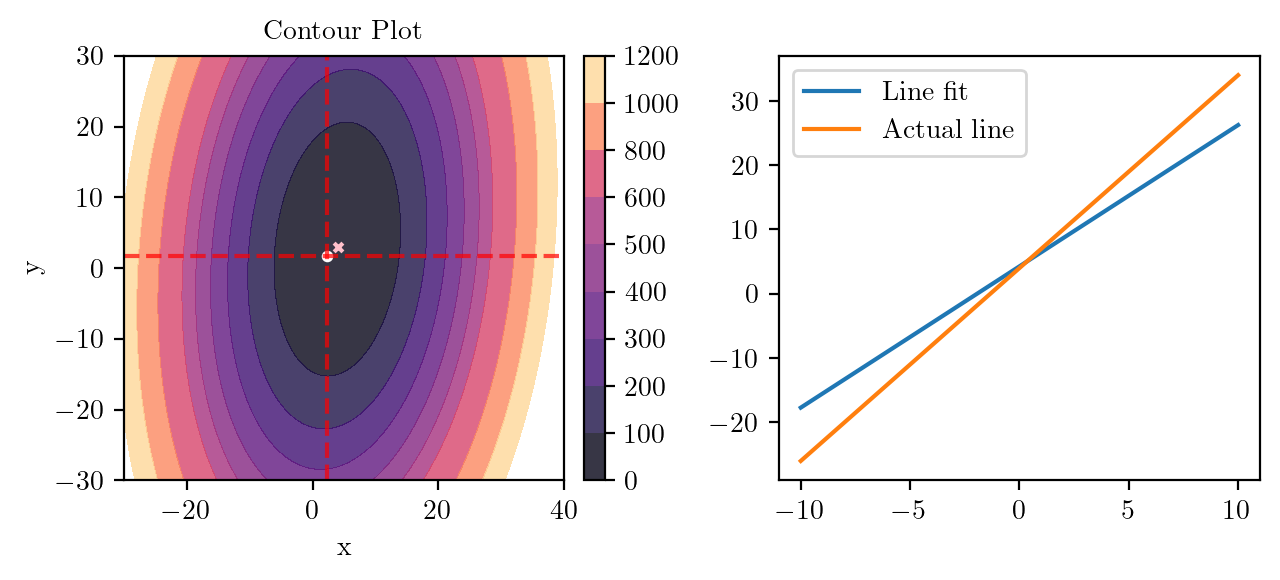

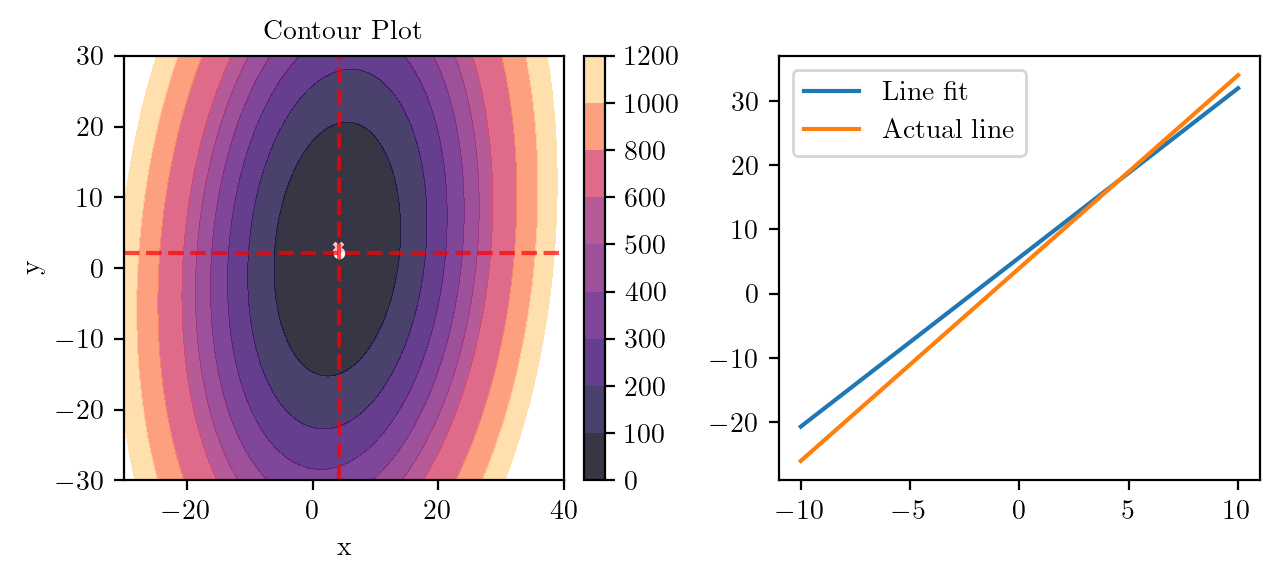

In [59]:
loss2 = visualize_descent(L1, x0, y0, v0, v1, [0, 100, 200, 300, 400, 500, 600, 800, 1000, 1200], "D2LMedia", "d", 4, 3, 0.75, 0.25)

## Visualization for Dataset2

!["D2"](./AllMedia/DL2.gif)

In [60]:
epsilon = 0.001

for i in range(1, len(loss2)):
    change_in_loss = np.abs(loss2[i] - loss2[i-1])
    print(change_in_loss)
    if change_in_loss < epsilon:
        print(f"Converged at iteration {i}")
        break

tensor(396.4966)
tensor(329.7534)
tensor(191.4899)
tensor(63.8271)
tensor(10.2025)
tensor(28.0963)
tensor(11.3582)
tensor(14.0467)
tensor(30.5940)
tensor(32.8604)
tensor(24.4292)
tensor(12.3182)
tensor(2.3910)
tensor(2.7189)


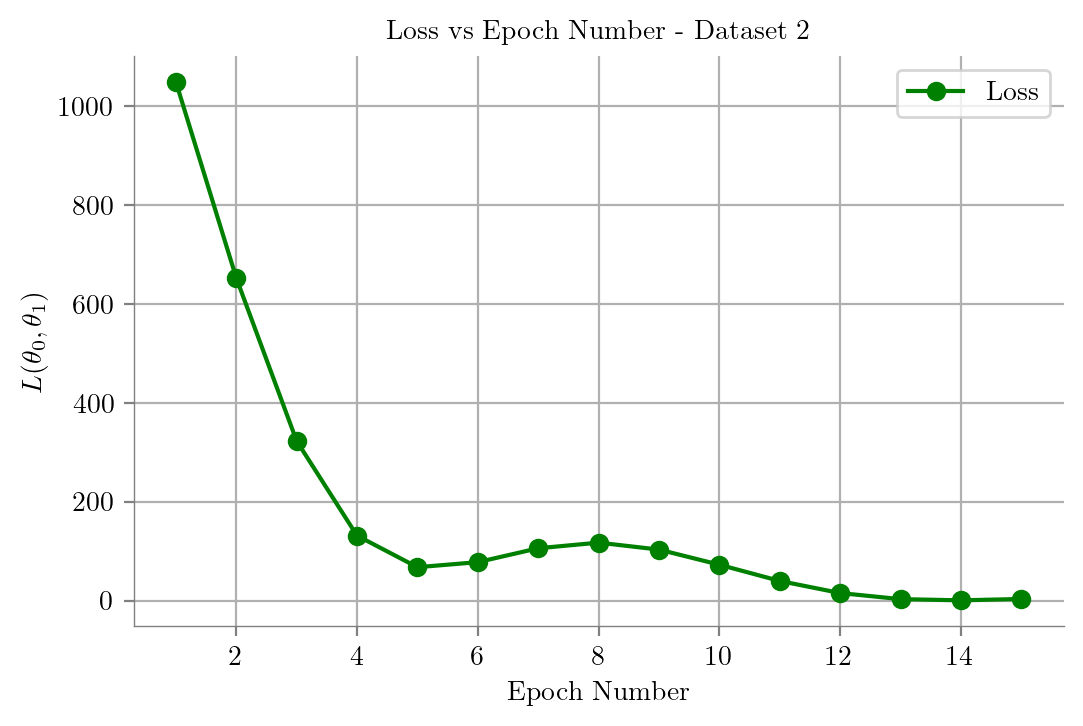

In [61]:
loss_plot(loss2, xlabel = "Epoch Number", ylabel = r"$L(\theta_0, \theta_1)$", title = "Loss vs Epoch Number - Dataset 2")

# Stochastic Gradient Descent

In [62]:
def visualize_sdg(x, y, x0, y0, v0, v1, epochs, levels, folderName, filename, t0, t1, alpha, p):
    losses = []
    latexify(columns=2, fig_width=6.5, fig_height=3)

    epsilon = 1e-3
    xi = x0
    yi = y0
    vi = v0
    wi = v1
    
    c = 0
    for i in range(epochs):
        shuffle_idx = np.random.permutation(len(x))
        x, y = x[shuffle_idx], y[shuffle_idx]
        
        for j in range(len(x)):
            
            def L(theta0, theta1):
                return (y[j] - theta0 - theta1*x[j])**2
            
            X, Y, Z, X_torch, Y_torch = create_XYZ(L)
            
            if (j % 10 == 0):
                fig, ax = plt.subplots()
                _, _ = create_contour(X, Y, Z, ax, alpha=0.8, scatter_pts=(xi, yi), filled=True, levels = levels)
                # Mark the minima with horizontal and vertical lines
                fig.suptitle(fr"Epoch No. {i + 1} Iteration No. {j + 1} $L(\theta_0, \theta_1) = ({y[j]} - \theta_0 - {x[j]}\theta_1)^2$", fontsize = 8)
                ax.axhline(y=yi, color='red', linestyle='--', alpha=0.7)
                ax.axvline(x=xi, color='red', linestyle='--', alpha=0.7)
                ax.scatter([t0], [t1], s=10, c='pink', marker='x', label='Minima')
            
            del_x, del_y = torch.func.grad(L, argnums=(0, 1))(xi, yi)
            losses.append(L(xi, yi))
            vi = p * vi + (1 - p) * del_x  
            wi = p * wi + (1 - p) * del_y
            
            xi = xi - alpha * vi
            yi = yi - alpha * wi
            
            if (torch.linalg.norm(torch.tensor([xi - t0, yi - t1])) < epsilon):
                break
            
            if (j % 10 == 0):
                print(f"Epoch No. {i + 1} Iteration No. {j + 1} -> {xi}, {yi}, Loss = {L(xi, yi)}, Nbhd = {torch.linalg.norm(torch.tensor([xi - t0, yi - t1]))}")
                # plt.tight_layout()
                plt.savefig(f"./{folderName}/{filename}-{c}.png", bbox_inches="tight")
                plt.close()
            
            
            c += 1
        print()
    return losses

# SDG for Dataset2

In [64]:
loss2_1 = visualize_sdg(x2, y2, torch.tensor(35.0), torch.tensor(-25.0), torch.tensor(1.0), torch.tensor(0.0), 15, [0, 100, 200, 300, 400, 500, 600, 800, 1000, 1200], "D4LMedia", "d", 4, 3, 0.25, 0.75)

Epoch No. 1 Iteration No. 1 -> 33.88819122314453, -25.782241821289062, Loss = 31.591655731201172, Nbhd = 41.493629455566406
Epoch No. 1 Iteration No. 11 -> -5.374091148376465, 7.283072471618652, Loss = 84.57054138183594, Nbhd = 10.30622673034668
Epoch No. 1 Iteration No. 21 -> 4.751775741577148, 9.97638988494873, Loss = 68.13531494140625, Nbhd = 7.016778945922852
Epoch No. 1 Iteration No. 31 -> 4.536127090454102, 0.919632613658905, Loss = 2.2669684886932373, Nbhd = 2.148339033126831

Epoch No. 2 Iteration No. 1 -> 4.158503532409668, 2.4186503887176514, Loss = 2.323333740234375, Nbhd = 0.602570116519928
Epoch No. 2 Iteration No. 11 -> 3.5401451587677, 3.007066011428833, Loss = 0.017487842589616776, Nbhd = 0.4599091410636902
Epoch No. 2 Iteration No. 21 -> 3.7525289058685303, 2.1846675872802734, Loss = 0.022711344063282013, Nbhd = 0.8520615696907043
Epoch No. 2 Iteration No. 31 -> 3.874723196029663, 2.99967360496521, Loss = 0.03295465558767319, Nbhd = 0.12527722120285034

Epoch No. 3 Ite

## SDG Visualization for Dataset2

!["SDG"](./AllMedia/DL4.gif)

In [69]:
epsilon = 0.001

for i in range(1, len(loss2_1)):
    change_in_loss = np.abs(loss2_1[i] - loss2_1[i-1])
    print(change_in_loss, end = " ")
    if change_in_loss < epsilon:
        print(f"Converged at iteration {i}")
        break

tensor(47.5518) tensor(2088.0500) tensor(1602.9125) tensor(644.3042) tensor(705.9775) tensor(24.2093) tensor(369.7652) tensor(63.6267) tensor(53.7489) tensor(56.4815) tensor(84.9328) tensor(13.2858) tensor(37.7679) tensor(38.5442) tensor(48.2450) tensor(4.2036) tensor(3.7683) tensor(62.7469) tensor(30.4186) tensor(116.1941) tensor(123.1146) tensor(14.7736) tensor(10.6224) tensor(4.4955) tensor(4.4424) tensor(4.4815) tensor(5.2177) tensor(0.0052) tensor(0.5453) tensor(2.0044) tensor(2.2920) tensor(4.4313) tensor(0.3916) tensor(3.6789) tensor(2.1128) tensor(1.4046) tensor(0.3878) tensor(0.4156) tensor(0.7219) tensor(4.1895) tensor(4.0835) tensor(0.3683) tensor(0.8145) tensor(0.4426) tensor(0.0148) tensor(1.4114) tensor(1.2782) tensor(2.4375) tensor(1.9629) tensor(2.3912) tensor(0.1137) tensor(3.1645) tensor(2.8844) tensor(0.0220) tensor(0.5870) tensor(0.0097) tensor(1.4968) tensor(1.4966) tensor(0.4747) tensor(0.4712) tensor(0.8334) tensor(0.7764) tensor(1.0009) tensor(0.9679) tensor(2.5

In [66]:
min_values = []
for i in range(15):
    subset = loss2_1[i * 40 : (i + 1) * 40]
    min_values.append(np.min(subset))
    
print(min_values)

[0.00032184814, 2.4725366e-06, 9.057696e-05, 0.0014371398, 0.0013900001, 0.0013080796, 0.00094962516, 0.00041253664, 1.2234043e-05, 0.0005695581, 0.0005845252, 8.397845e-05, 8.165476e-05, 9.9266086e-05, 0.002383147]


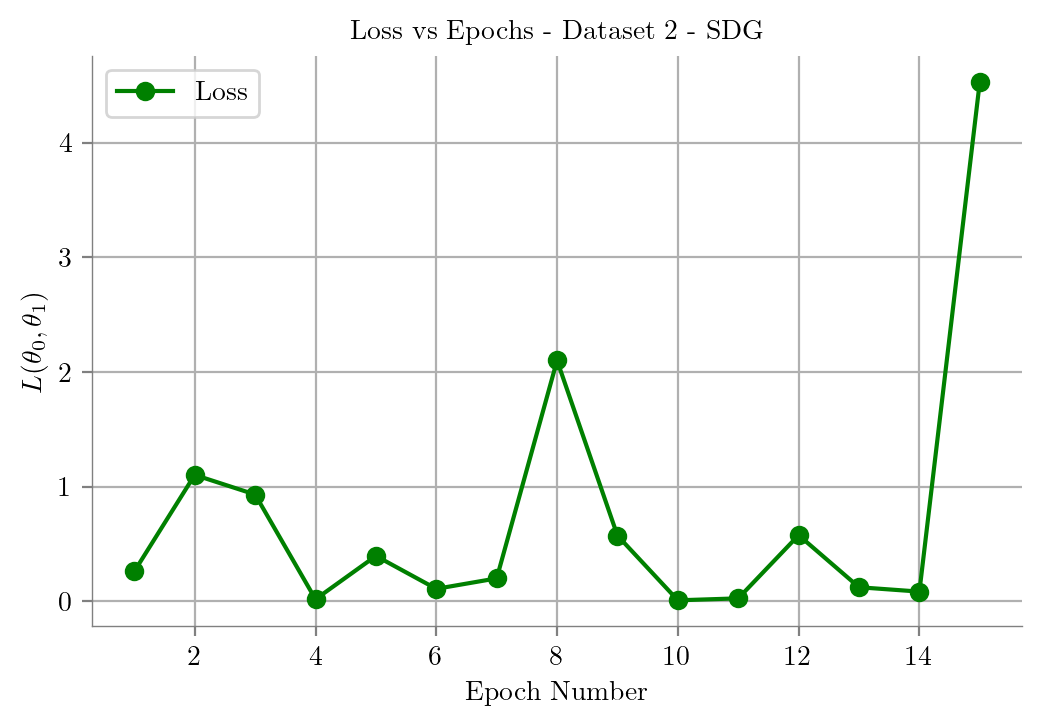

In [67]:
idxs = list(range(39, len(loss2_1), 40))
loss_plot(np.array(loss2_1)[idxs], xlabel = "Epoch Number", ylabel = r"$L(\theta_0, \theta_1)$", title = "Loss vs Epochs - Dataset 2 - SDG")

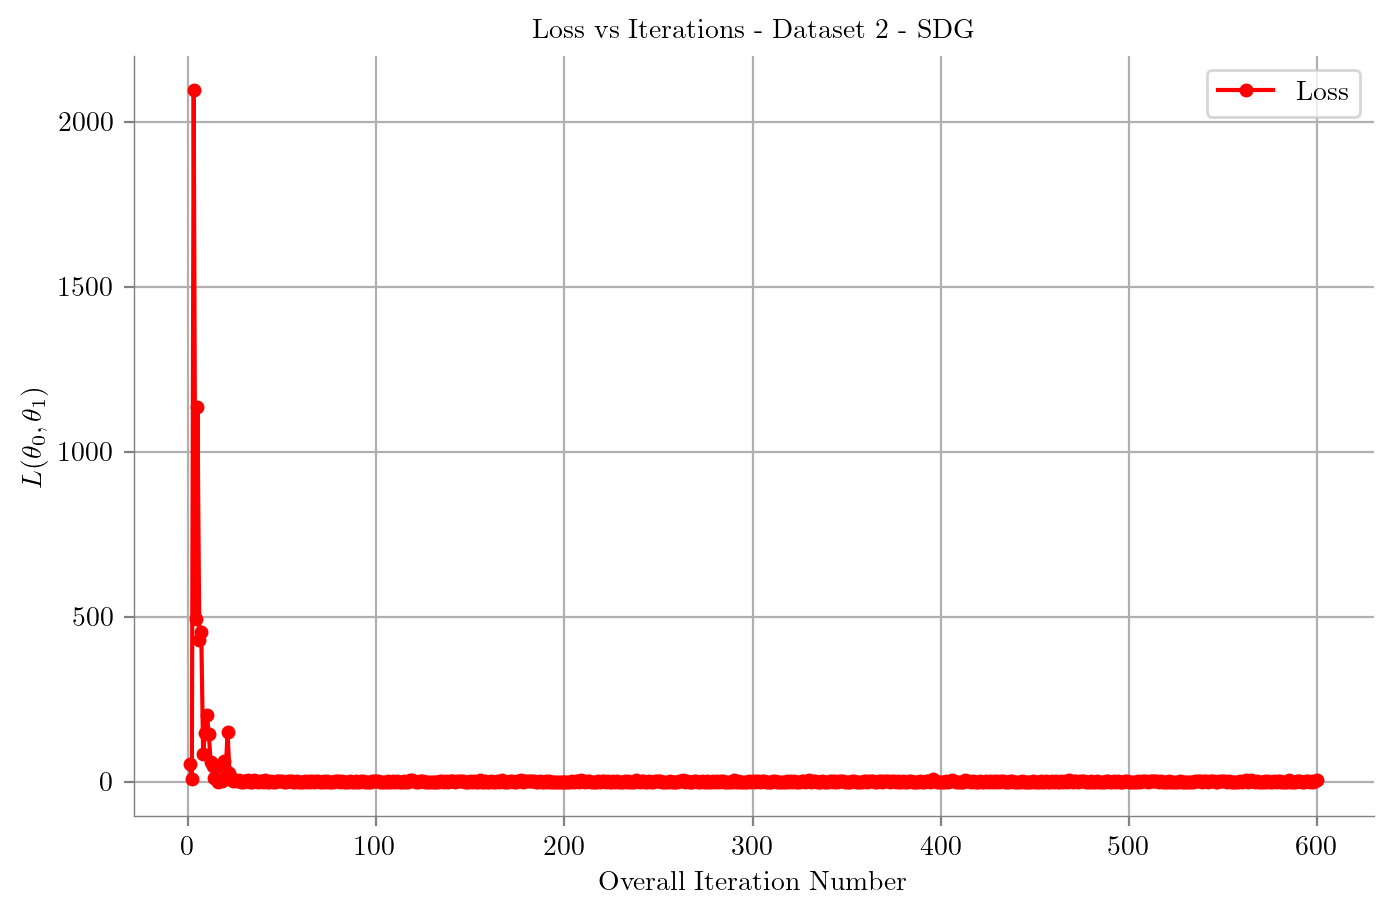

In [68]:
latexify(columns = 2, fig_width = 8)
plt.plot(range(1, len(loss2_1) + 1), loss2_1, marker = "o", label = "Loss", color = "red", markersize = 4)
plt.xlabel("Overall Iteration Number")
plt.ylabel(r"$L(\theta_0, \theta_1)$")
# plt.axvline(x = 129, color = "black", linestyle = "--", label = f"Convergence {129}")
plt.title("Loss vs Iterations - Dataset 2 - SDG")
plt.grid()
plt.legend()
format_axes(plt.gca())
plt.show()

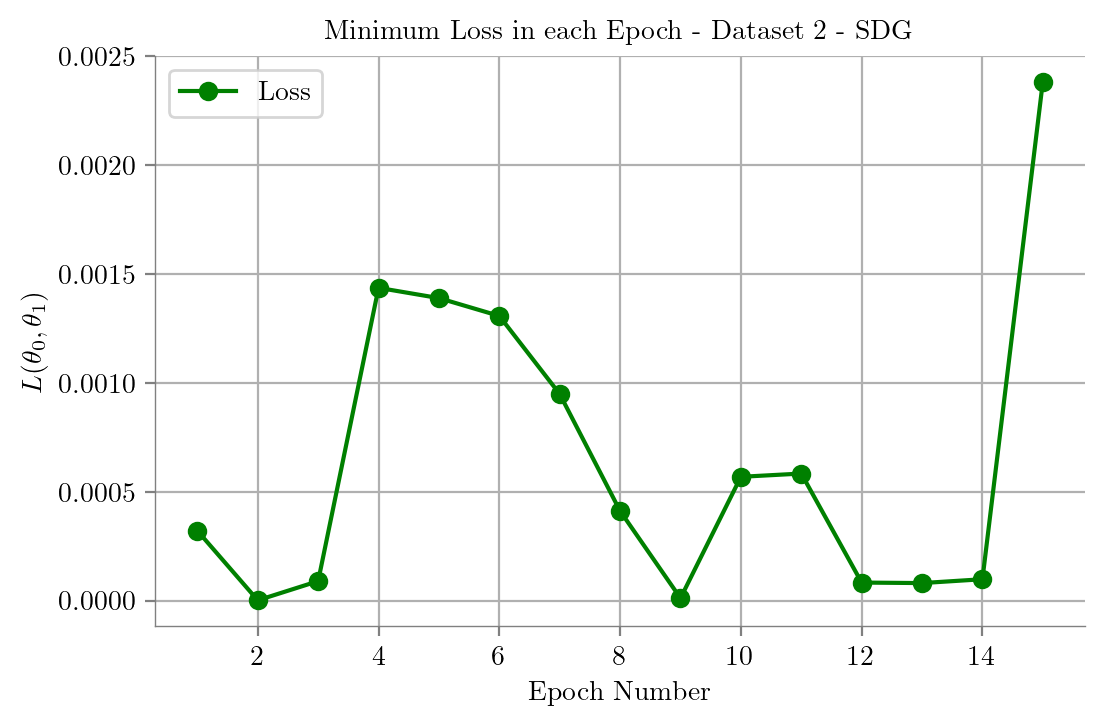

In [70]:
loss_plot(min_values, xlabel = "Epoch Number", ylabel = r"$L(\theta_0, \theta_1)$", title = "Minimum Loss in each Epoch - Dataset 2 - SDG")

# SDG for Dataset1

In [81]:
loss1_1 = visualize_sdg(x1, y1, torch.tensor(1.5), torch.tensor(93.0), torch.tensor(0.0), torch.tensor(0.0), 15, [0, 1000, 2000, 3000, 5000, 7000, 15000, 25000], "D3LMedia", "d", 1, 100, 0.001, 0.99)

Epoch No. 1 Iteration No. 1 -> 1.4987623691558838, 93.01081848144531, Loss = 3817.827880859375, Nbhd = 7.006955146789551
Epoch No. 1 Iteration No. 11 -> 1.4461172819137573, 94.1707534790039, Loss = 9629.2578125, Nbhd = 5.846292495727539
Epoch No. 1 Iteration No. 21 -> 1.362715721130371, 96.81143951416016, Loss = 1954.650146484375, Nbhd = 3.2091245651245117
Epoch No. 1 Iteration No. 31 -> 1.2787598371505737, 99.78394317626953, Loss = 1.5885860919952393, Nbhd = 0.3526862561702728

Epoch No. 2 Iteration No. 1 -> 1.197295069694519, 102.56109619140625, Loss = 93.86066436767578, Nbhd = 2.5686843395233154
Epoch No. 2 Iteration No. 11 -> 1.1525455713272095, 104.33866882324219, Loss = 6663.79638671875, Nbhd = 4.3413496017456055
Epoch No. 2 Iteration No. 21 -> 1.1341296434402466, 104.62881469726562, Loss = 6173.60107421875, Nbhd = 4.630757808685303
Epoch No. 2 Iteration No. 31 -> 1.0912829637527466, 103.68964385986328, Loss = 18.285619735717773, Nbhd = 3.690772771835327

Epoch No. 3 Iteration No

In [82]:
epsilon = 0.001

for i in range(1, len(loss1_1)):
    change_in_loss = np.abs(loss1_1[i] - loss1_1[i-1])
    print(change_in_loss, end = " ")
    if change_in_loss < epsilon:
        print(f"Converged at iteration {i}")
        break

tensor(2179.4023) tensor(10136.4941) tensor(6033.5610) tensor(7514.9224) tensor(5917.8115) tensor(2860.3062) tensor(4228.4707) tensor(9402.9404) tensor(9117.6074) tensor(9750.4189) tensor(3997.1758) tensor(5561.7554) tensor(6161.2788) tensor(2988.9268) tensor(8033.9590) tensor(1829.1562) tensor(465.7578) tensor(393.1555) tensor(815.5776) tensor(1422.6934) tensor(2336.2476) tensor(1088.7268) tensor(1082.0950) tensor(1816.5742) tensor(1762.1830) tensor(45.8740) tensor(528.2836) tensor(97.4222) tensor(429.7990) tensor(12.8799) tensor(11.4109) tensor(12.7734) tensor(0.8533) tensor(59.1019) tensor(61.4539) tensor(105.2782) tensor(94.1750) tensor(1100.7710) tensor(350.1266) tensor(688.9119) tensor(41.5126) tensor(1766.9137) tensor(779.9056) tensor(1609.6960) tensor(833.0327) tensor(1871.0104) tensor(2709.5386) tensor(4234.8438) tensor(1895.7616) tensor(4390.4619) tensor(4381.9224) tensor(40.3198) tensor(2887.8838) tensor(4802.9580) tensor(1112.1129) tensor(3467.5532) tensor(4143.6802) tensor

In [83]:
min_values1 = []
for i in range(15):
    subset = loss1_1[i * 40 : (i + 1) * 40]
    min_values1.append(np.min(subset))
    
print(min_values1)

[0.07977461, 6.2054477, 0.049074255, 0.0006419747, 1.7525855, 0.40813568, 0.0029123856, 0.010533043, 0.11893637, 0.021952227, 0.0062860586, 0.007301569, 0.017146148, 0.049739018, 0.04775148]


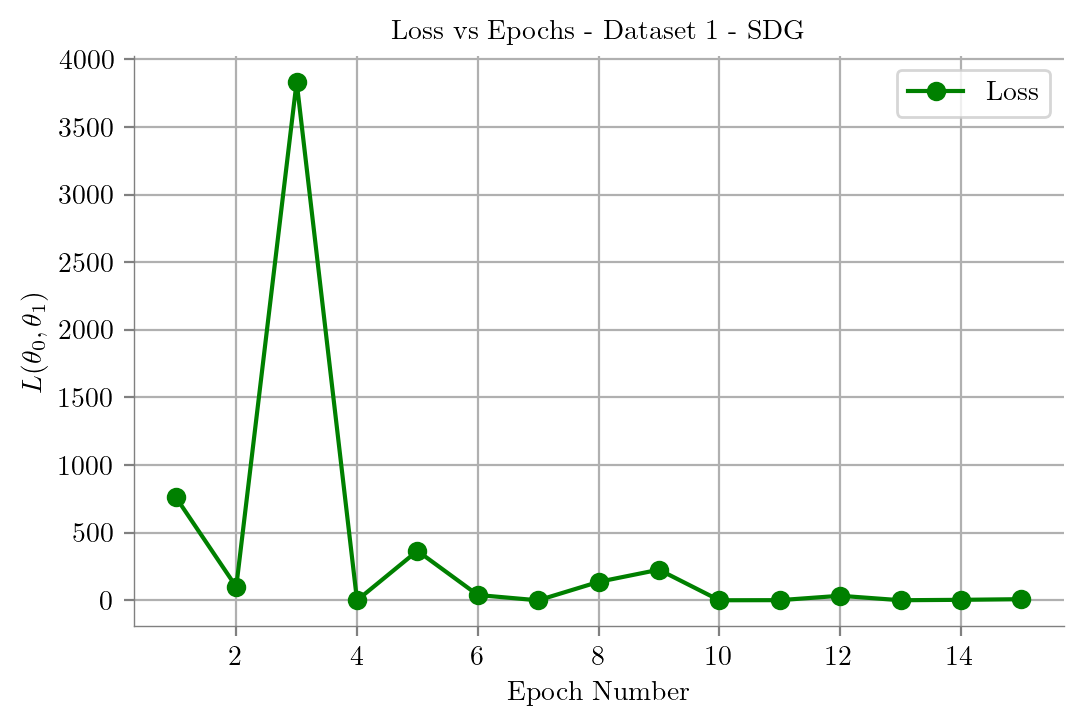

In [84]:
idxs = list(range(39, len(loss1_1), 40))
loss_plot(np.array(loss1_1)[idxs], xlabel = "Epoch Number", ylabel = r"$L(\theta_0, \theta_1)$", title = "Loss vs Epochs - Dataset 1 - SDG")

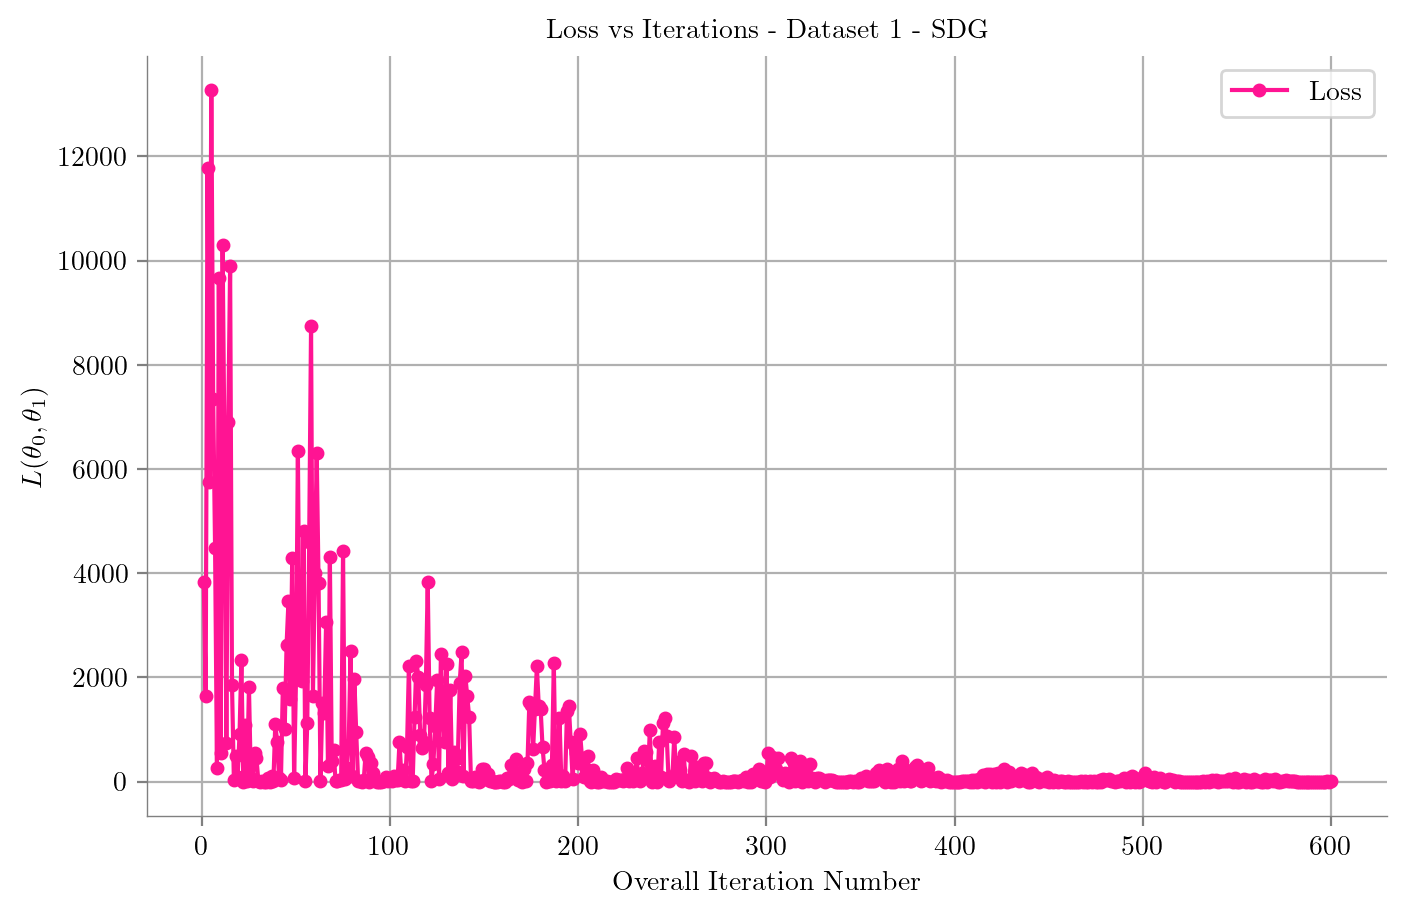

In [85]:
latexify(columns = 2, fig_width = 8)
plt.plot(range(1, len(loss1_1) + 1), loss1_1, marker = "o", label = "Loss", color = "deeppink", markersize = 4)
plt.xlabel("Overall Iteration Number")
plt.ylabel(r"$L(\theta_0, \theta_1)$")
plt.title("Loss vs Iterations - Dataset 1 - SDG")
# plt.axvline(x = 458, color = "black", linestyle = "--", label = f"Convergence {459}")
plt.grid()
plt.legend()
format_axes(plt.gca())
plt.show()

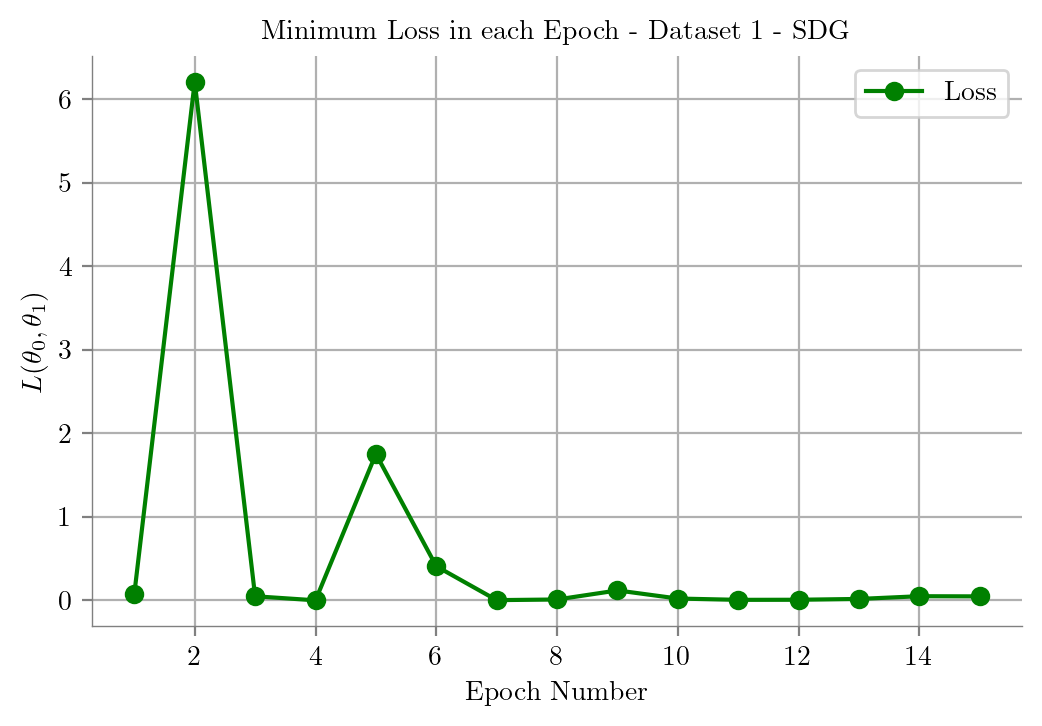

In [86]:
loss_plot(min_values1, xlabel = "Epoch Number", ylabel = r"$L(\theta_0, \theta_1)$", title = "Minimum Loss in each Epoch - Dataset 1 - SDG")

## SDG Visualization for Dataset1

!["SDG"](./AllMedia/DL3.gif)